# Backtest of **Intra-Day** Risk-Control Reweighting using Quantile Forecasts from a Bayesian Joint Quantile Time Series Model For Asset Returns

## Import packages

### Import libraries


In [142]:
# Standard library imports
import os      # Operating system interfaces
import sys     # System-specific parameters and functions
import json    # JSON encoder and decoder

# API Libraries and Data Extraction
import yfinance as yf  # Yahoo Finance API for financial data extraction

# Data manipulation and analysis
import pandas as pd      # DataFrame and data analysis
import numpy as np       # Numerical operations
import openpyxl as px   # Excel file reading and writing
import h5py    # HDF5 file format for storing large datasets
from scipy.io import loadmat # MATLAB file format for loading data
from itertools import product # For generating combinations of parameters

# Plotting and visualization
import matplotlib.pyplot as plt           # Static plotting
import matplotlib.dates as mdates         # Date formatting for matplotlib
import matplotlib.colors as mcolors       # Color utilities for matplotlib for different line series colours
import plotly.graph_objs as go            # Interactive plotting
from IPython.display import display # Display objects in Jupyter notebooks
## Interactive Plotting
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go


## Grammar of graphics plotting (ggplot-style)
from plotnine import *                   # Main plotnine API for ggplot-style plotting
from plotnine.scales import scale_x_date # For date scaling on x-axis in plotnine



# Warnings control
import warnings  # Warning control
from plotnine.exceptions import PlotnineWarning


### Import Custom Packages

In [100]:
#parent_dir = os.path.join(os.getcwd(),"../src")
#sys.path.insert(0, parent_dir)
#from stats_utils import sql_queries as sqlq

## Import S&P Capital IQ Data for SPX and SPY

In [101]:
# import the interday S&P 500 data from the csv file in the data directory
sp500_intraday_raw = pd.read_excel("../data/input/spx_spy_CIQ_Pro_10_min_max.xlsx")

## Clean The CIQ Data

### Change Column Names

In [102]:
# Rename the columns to time, val_wgt_ret_w_div, level, base_return, in that order
sp500_intraday_v1 = sp500_intraday_raw.copy()
sp500_intraday_v1.columns = ['time', 'spx_level', 'spy_level']



### Clean the date column

In [103]:
# convert time column to string first
sp500_intraday_v2 = sp500_intraday_v1.copy()
sp500_intraday_v2['time'] = sp500_intraday_v2['time'].astype(str)

# split the time column upon - (only applies to the misformatted dates)
# these dates are in yyyy-dd-mm hh:mm:ss format when should be mm/dd/yyyy hh:mm (US format)
# for each row that contains a '-' in the time string, move the yyyy so that it goes after
# the dd and mm but before the hh:mm
#regex = r'[\s-]+'
#sp500_intraday['time'] = sp500_intraday['time'].apply(lambda x:
#                                                        f"{x.split(regex)[1]}/{x.split(regex)[2]}/{x.split(regex)[0]} {x.split(' ')[1]}"
#                                                         if '-' in x else x)
sp500_intraday_v2['time'] = sp500_intraday_v2['time'].str.split(r'[\s\-/]+', expand=False)

# identify if the first part is greater than 12, then it's yyyy-dd-mm
sp500_intraday_v2['time'] = sp500_intraday_v2['time'].apply(lambda x: 
                                                         f"{x[2]}/{x[1]}/{x[0]} {x[3][:-3]}"
                                                         if int(x[0]) == 2025 else f"{x[0]}/{x[1]}/{x[2]} {x[3]}")



In [104]:
sp500_intraday_v2

,time,spx_level,spy_level
0,12/26/2025 16:20,6929.94,NaN
1,12/26/2025 16:15,NaN,690.31
2,12/26/2025 16:10,6929.94,NaN
3,12/26/2025 16:00,6929.94,690.24
4,12/26/2025 15:50,6930.52,690.25
...,...,...,...
850,11/28/2025 10:00,6829.63,679.48
851,11/28/2025 09:50,6826.03,679.23
852,11/28/2025 09:40,6830.12,679.52
853,11/28/2025 09:30,6825.28,679.06


In [105]:
# Convert the time column to datetime format, 
# considering they are currently string format as dd/mm/yyyy hh:mm
sp500_intraday_v3 = sp500_intraday_v2.copy()
sp500_intraday_v3['time'] = pd.to_datetime(sp500_intraday_v3['time'], format='%m/%d/%Y %H:%M')
# sort in ascending order
sp500_intraday_v3 = sp500_intraday_v3.drop_duplicates().sort_values(by = 'time' ,ascending=True).reset_index().drop('index', axis=1)

#convert back to object
#sp500_intraday['time_label'] = sp500_intraday['time'].astype(object)


In [106]:
sp500_intraday_v3

,time,spx_level,spy_level
0,2025-11-10 19:00:00,NaN,NaN
1,2025-11-28 09:30:00,6825.28,679.06
2,2025-11-28 09:40:00,6830.12,679.52
3,2025-11-28 09:50:00,6826.03,679.23
4,2025-11-28 10:00:00,6829.63,679.48
...,...,...,...
849,2025-12-26 15:50:00,6930.52,690.25
850,2025-12-26 16:00:00,6929.94,690.24
851,2025-12-26 16:10:00,6929.94,NaN
852,2025-12-26 16:15:00,NaN,690.31


### CIQ Data Plot

In [107]:
# Check the CIQ data on its own
plot_ciq = sp500_intraday_v3
#.dropna().reset_index().drop('index', axis=1)
# sort in ascending time order
plot_ciq = plot_ciq.sort_values(by='time', ascending=True)
# select only the dates past 2025-12-01 14:30:00 to match with the merged data
plot_ciq = plot_ciq[plot_ciq['time'] >= pd.to_datetime('2025-12-01 14:30:00')].reset_index().drop('index', axis=1)
plot_ciq

,time,spx_level,spy_level
0,2025-12-01 14:30:00,6823.29,678.98
1,2025-12-01 14:40:00,6816.10,678.24
2,2025-12-01 14:50:00,6815.41,678.22
3,2025-12-01 15:00:00,6818.48,678.49
4,2025-12-01 15:10:00,6818.87,678.45
...,...,...,...
791,2025-12-26 15:50:00,6930.52,690.25
792,2025-12-26 16:00:00,6929.94,690.24
793,2025-12-26 16:10:00,6929.94,NaN
794,2025-12-26 16:15:00,NaN,690.31


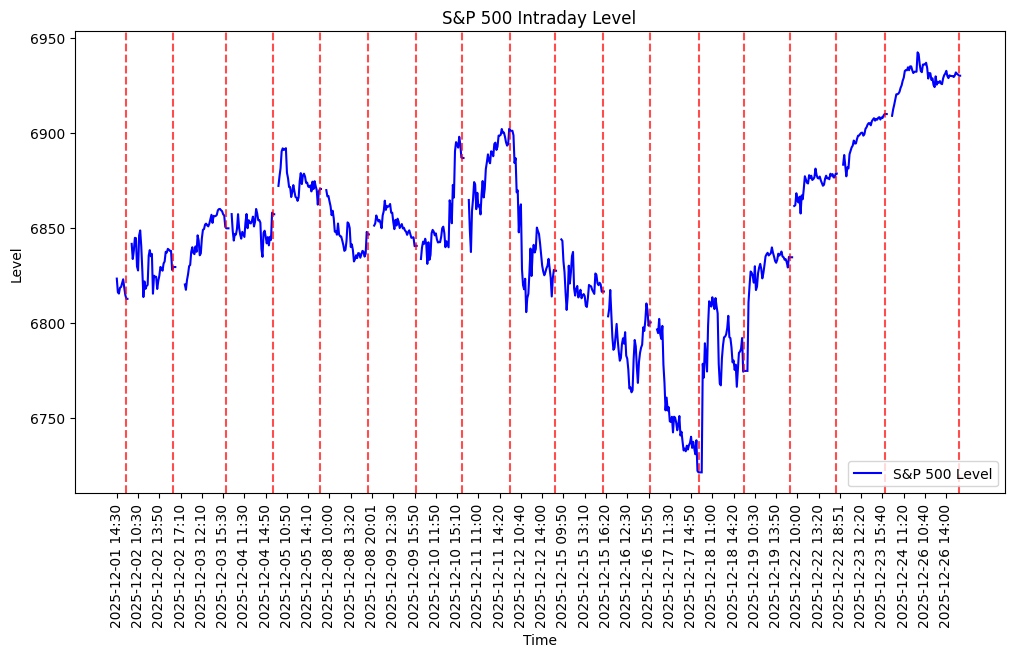

In [108]:


# plot the price series
plt.figure(figsize=(12, 6)) 
plt.plot( plot_ciq['spx_level'], label='S&P 500 Level', color='blue')
# add ticklabels using the time column
plt.xticks(ticks=range(0, len(plot_ciq), 20), 
          labels=plot_ciq['time'].dt.strftime('%Y-%m-%d %H:%M').iloc[::20], rotation=90)  
# insert a vline wherever the plot_ciq['time'] value has 16:00 hours
for i, time in enumerate(plot_ciq['time']):
    if time.hour == 16 and time.minute == 0:
        plt.axvline(x=i, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Level')
plt.title('S&P 500 Intraday Level')
plt.legend()
plt.show()


## Add new columns

In [109]:
# drop empty rows
sp500_intraday_v4 = sp500_intraday_v3.copy().dropna().reset_index().drop('index', axis=1)

### Add log return and cumulative return columns

In [110]:
def get_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate returns and technical indicators for the given DataFrame.
    Args:
        df (pd.DataFrame): DataFrame containing stock data with 'open' and 'close' columns.
    Returns:
        pd.DataFrame: DataFrame with additional columns for returns and technical indicators.
    """     
    # Calculate log returns for each column containing 'level' (and cumulative log returns)
    level_cols = [col for col in df.columns if 'level' in col]
    
    for col in level_cols:
        return_col = col.replace('_level', '_period_return')  # e.g., 'spx_level' -> 'spx_day_return'
        total_return_col = col.replace('_level', '_total_return')
        df.loc[1:, return_col] = np.log(df[col].values[1:] / df[col].values[:-1])
        sum_of_returns = df[return_col].cumsum()
        df.loc[:, total_return_col] = np.exp(sum_of_returns) - 1
        #print(return_col)
        #print(df[return_col].cumsum().head())
        #print((np.exp(df[return_col].cumsum()) -1).head())
    


    return df

sp500_intraday_returns = get_returns(sp500_intraday_v4)




In [111]:
sp500_intraday_returns["spx_total_return"] =sp500_intraday_returns["spx_period_return"].cumsum()

In [112]:
sp500_intraday_returns

,time,spx_level,spy_level,spx_period_return,spx_total_return,spy_period_return,spy_total_return
0,2025-11-28 09:30:00,6825.28,679.06,NaN,NaN,NaN,NaN
1,2025-11-28 09:40:00,6830.12,679.52,0.000709,0.000709,0.000677,0.000677
2,2025-11-28 09:50:00,6826.03,679.23,-0.000599,0.000110,-0.000427,0.000250
3,2025-11-28 10:00:00,6829.63,679.48,0.000527,0.000637,0.000368,0.000619
4,2025-11-28 10:10:00,6833.94,679.99,0.000631,0.001268,0.000750,0.001370
...,...,...,...,...,...,...,...
762,2025-12-26 15:20:00,6930.09,690.20,0.000120,0.015239,0.000058,0.016405
763,2025-12-26 15:30:00,6931.67,690.38,0.000228,0.015467,0.000261,0.016670
764,2025-12-26 15:40:00,6931.01,690.31,-0.000095,0.015372,-0.000101,0.016567
765,2025-12-26 15:50:00,6930.52,690.25,-0.000071,0.015301,-0.000087,0.016479


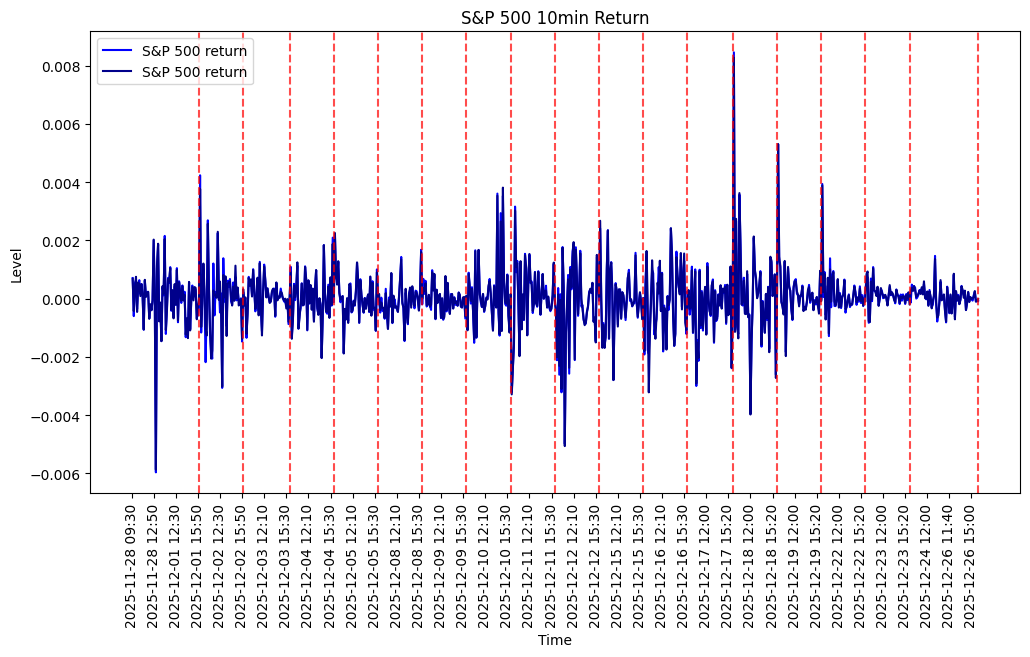

In [113]:
# simple plot of returns for spx in each period and total return in each period


# plot the price series
plt.figure(figsize=(12, 6)) 
plt.plot( sp500_intraday_returns['spx_period_return'], label='S&P 500 return', color='blue')
plt.plot( sp500_intraday_returns['spy_period_return'], label='S&P 500 return', color='darkblue')
# add ticklabels using the time column
plt.xticks(ticks=range(0, len(sp500_intraday_returns), 20), 
          labels=sp500_intraday_returns['time'].dt.strftime('%Y-%m-%d %H:%M').iloc[::20], rotation=90)  
# insert a vline wherever the plot_ciq['time'] value has 16:00 hours
for i, time in enumerate(sp500_intraday_returns['time']):
    if time.hour == 16 and time.minute == 0:
        plt.axvline(x=i, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Level')
plt.title('S&P 500 10min Return')
plt.legend()
plt.show()

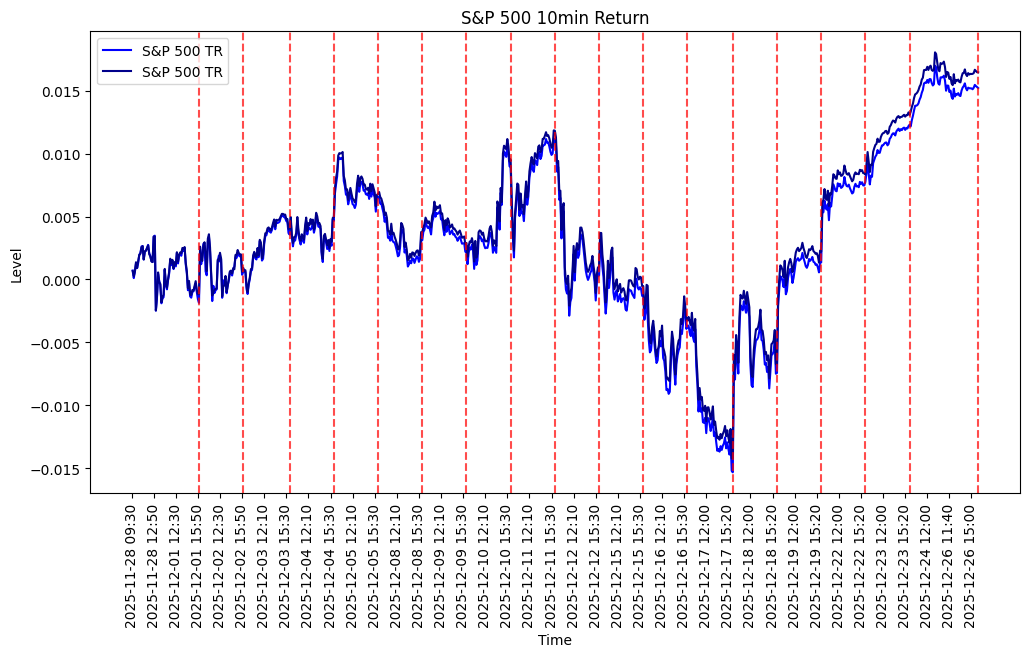

In [114]:
# simple plot of total returns for spx in each period and total return in each period


# plot the price series
plt.figure(figsize=(12, 6)) 
plt.plot( sp500_intraday_returns['spx_total_return'], label='S&P 500 TR', color='blue')
plt.plot( sp500_intraday_returns['spy_total_return'], label='S&P 500 TR', color='darkblue')
# add ticklabels using the time column
plt.xticks(ticks=range(0, len(sp500_intraday_returns), 20), 
          labels=sp500_intraday_returns['time'].dt.strftime('%Y-%m-%d %H:%M').iloc[::20], rotation=90)  
# insert a vline wherever the plot_ciq['time'] value has 16:00 hours
for i, time in enumerate(sp500_intraday_returns['time']):
    if time.hour == 16 and time.minute == 0:
        plt.axvline(x=i, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Level')
plt.title('S&P 500 10min Return')
plt.legend()
plt.show()

## Compare the total Return of the Index VS the ETF

### Pre-Plotting Cleaning

#### Change to Dataframe Format

In [115]:
# Melt the dataframe to long format for plotting
# get the subset we want to plot:
sp500_subset = sp500_intraday_returns[['time','spx_total_return','spy_total_return']]
sp500_subset['second_index'] = sp500_subset.index
# for each date, we have 1 value each for each of the total returns columns
plot_df = sp500_subset.melt(
    id_vars=['time','second_index'],
    # choose the value variables to be all the column names that end with 'level'
    value_vars= [ col for col in sp500_subset.columns if col.endswith('total_return')],
    value_name='total_return'
)

# drop the nan values, which will be for the first day
plot_df = plot_df.dropna(subset=['total_return'])

# add a time label column that is just the datetime time column as an object
plot_df['time_label'] = plot_df['time'].astype(object)


# multiply by 100
#plot_df['total_return'] = plot_df['total_return']*100

#plot_df

C:\Users\danie\AppData\Local\Temp\ipykernel_31872\3572412600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [116]:
plot_df

,time,second_index,variable,total_return,time_label
1,2025-11-28 09:40:00,1,spx_total_return,0.000709,2025-11-28 09:40:00
2,2025-11-28 09:50:00,2,spx_total_return,0.000110,2025-11-28 09:50:00
3,2025-11-28 10:00:00,3,spx_total_return,0.000637,2025-11-28 10:00:00
4,2025-11-28 10:10:00,4,spx_total_return,0.001268,2025-11-28 10:10:00
5,2025-11-28 10:20:00,5,spx_total_return,0.000904,2025-11-28 10:20:00
...,...,...,...,...,...
1529,2025-12-26 15:20:00,762,spy_total_return,0.016405,2025-12-26 15:20:00
1530,2025-12-26 15:30:00,763,spy_total_return,0.016670,2025-12-26 15:30:00
1531,2025-12-26 15:40:00,764,spy_total_return,0.016567,2025-12-26 15:40:00
1532,2025-12-26 15:50:00,765,spy_total_return,0.016479,2025-12-26 15:50:00


#### Add a Label Mapping for Each Type of Return

In [117]:
# Get the unique return types from the melted DataFrame
series_types = plot_df['variable'].dropna().unique()

# Create a label mapping that maps the return types to more compact labels
label_mapping = {
    'spx_total_return': 'S&P 500 \n Index TR',
    'spy_total_return': 'SPY ETF \n TR'
}

#### Add a Colour Mapping for Each type of Return

In [118]:
# Create a mapping for colors for each series_types using a yellow to red gradient

# Use matplotlib's colormap to generate a yellow-to-red spectrum
cmap = plt.get_cmap('autumn')  # yellow to red
colors = [mcolors.to_hex(cmap(i / max(1, (len(series_types) - 1)))) for i in range(len(series_types))]
# Map each return_type to a color
color_map = dict(zip(series_types, colors))

In [119]:
color_map

{'spx_total_return': '#ff0000', 'spy_total_return': '#ffff00'}

### X Series Labels

In [120]:
# 1. Select relevant columns and remove duplicates
label_df = plot_df[['time','second_index']].drop_duplicates(subset = ['second_index'])

# 2. Choose evenly spaced rows to get at most 10 unique ticks
n_ticks = min(10, len(label_df))
step = max(1, len(label_df) // n_ticks)
label_df_filtered = label_df.iloc[::step].head(n_ticks)

# 3. Extract breaks and labels
time_breaks = label_df_filtered['second_index'].tolist()
time_labels = label_df_filtered['time'].tolist()

In [121]:
time_breaks[:5]

[1, 77, 153, 229, 305]

### Plot the Prices and Index Levels of Each Series and Data Source

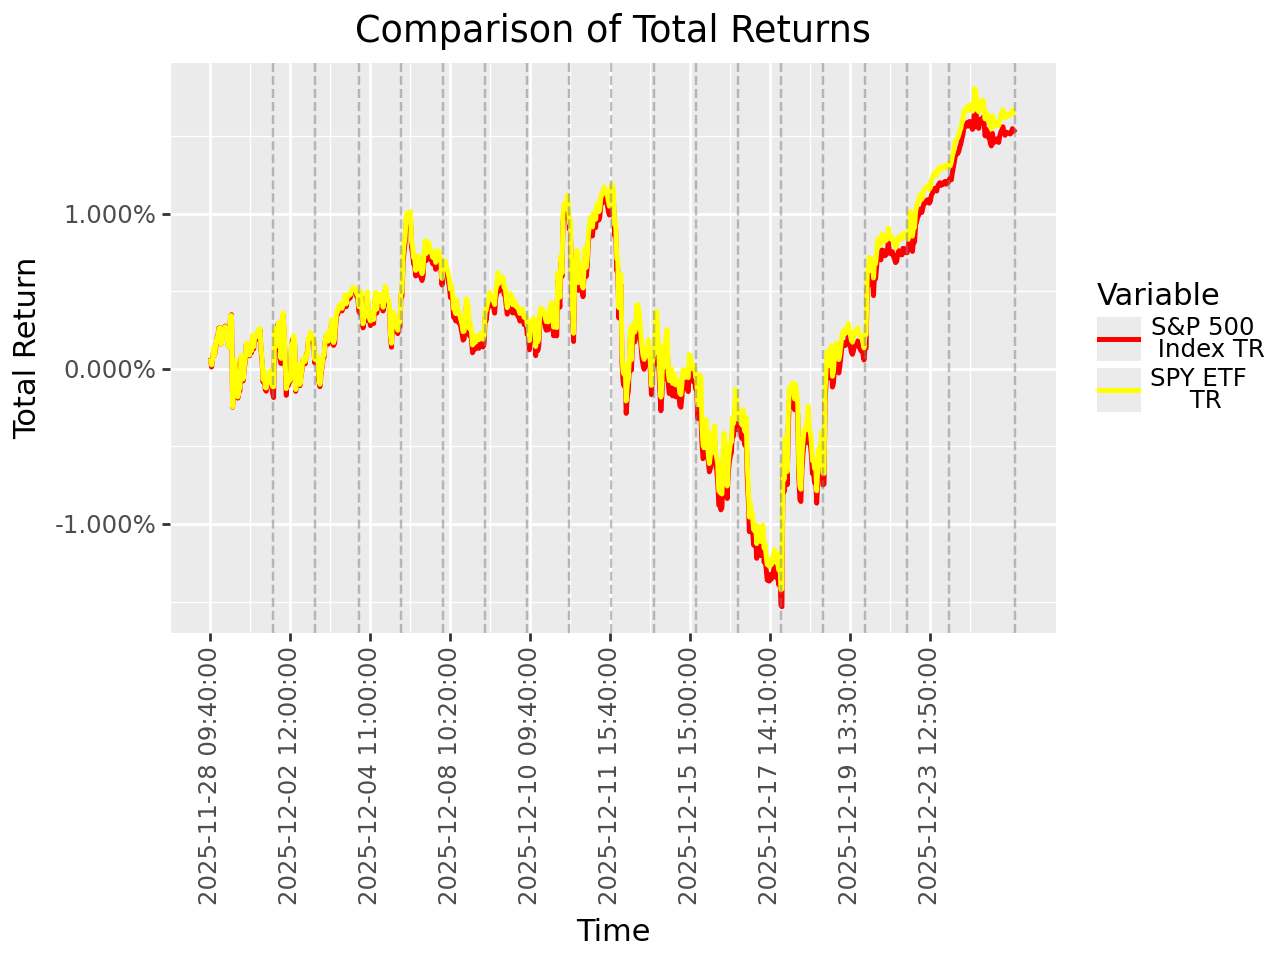

In [122]:
### Plot Each Series On One Plot

def plot_series(
    plot_df=plot_df,
    y='value',
    plot_title='Values Over Time',
    y_title='Value',
    display_plot=True
):
    # suppress missing value warnings
    warnings.filterwarnings('ignore', category=PlotnineWarning)

    # Use global color_map, commodity_labels, date_breaks, date_labels
    # Create the plot using plotnine (ggplot-style)
    plot = (
        # Set up the basic plot with aesthetics: x=time, y=selected y, color by return_type
        ggplot(plot_df, aes(x=plot_df['second_index'], y=y, color='variable')) +
        # Draw lines for each return_type
        geom_line(size=1) +
        # Manually set colors for each return_type using the color_map and set legend labels
        scale_color_manual(values=color_map, labels=label_mapping) +
        # Set plot and axis labels
        labs(
            title=plot_title,
            x='Time',
            y=y_title,
            color='Variable'
        ) +
        scale_x_continuous(breaks=time_breaks, labels=time_labels) +
        # Format y-axis as percentage values
        scale_y_continuous(labels=lambda l: [f"{v*100:.3f}%" for v in l]) +
        # add a vertical line at each daily close (16:00 hours)
        geom_vline(xintercept=[i for i, time in enumerate(plot_df['time'][:plot_df['second_index'].max()]) if time.hour == 16 and time.minute == 0],
                   color='grey', linetype='dashed', alpha=0.5) +
      
        # Customize theme: rotate x labels, move legend, center title
        theme(
            axis_text_x=element_text(rotation=90, ha='center'),
            legend_position='right',
            plot_title=element_text(ha='center')
        ) +
        # Remove linetype guide from legend
        guides(linetype=None)
    )

    # Save plot to file
    fig_path = f"../docs/figures/{plot_title}.png"
    plot.save(fig_path, width=10, height=6, dpi=300)

    # Display plot if requested
    if display_plot:
        display(plot)

    return plot

plot_1 = plot_series(
    plot_df=plot_df,
    y='total_return',
    plot_title='Comparison of Total Returns',
    y_title='Total Return',
    display_plot=True
)


### Save Out to Excel File for Processing

In [141]:
# select only the spx level with the datetime time column
spx_excel_intraday = sp500_intraday_returns[['time','spx_period_return']].copy()

# save out to excel
spx_excel_intraday.to_excel("../data/intermediate_input/spx_intraday_returns.xlsx", index=False)

## Import Yahoo Finance Data for SPX, SPY and ES

In [123]:
# Import 15 minute frequency data for SPX
spx_15_mn_yf = yf.download("^GSPC", interval="5m", period="60d")
# Import 15 minute frequency data for SPY
spy_15_min_yf = yf.download("SPY", interval="5m", period="60d")
# Import 15 minute frequency data for ES
es_15_min_yf = yf.download("ES=F", interval="5m", period="60d")



C:\Users\danie\AppData\Local\Temp\ipykernel_31872\2756754222.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed
C:\Users\danie\AppData\Local\Temp\ipykernel_31872\2756754222.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed
C:\Users\danie\AppData\Local\Temp\ipykernel_31872\2756754222.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed


In [124]:
spx_15_mn_yf

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Datetime,,,,,
2025-10-02 13:30:00+00:00,6728.529785,6731.939941,6724.250000,6731.310059,0
2025-10-02 13:35:00+00:00,6722.799805,6730.000000,6722.240234,6728.310059,65210952
2025-10-02 13:40:00+00:00,6715.080078,6722.770020,6713.660156,6722.740234,60938632
2025-10-02 13:45:00+00:00,6715.220215,6720.910156,6713.859863,6714.899902,59697104
2025-10-02 13:50:00+00:00,6719.830078,6721.160156,6711.759766,6715.430176,50237542
...,...,...,...,...,...
2025-12-26 20:35:00+00:00,6931.669922,6932.140137,6930.330078,6930.520020,18305000
2025-12-26 20:40:00+00:00,6932.500000,6932.850098,6931.259766,6931.629883,20378000


## Clean The Yahoo Finance Data

### Merge the Yahoo Finance Datasets

In [125]:
# Merge these 3 datasets' first columns (close) on their datetime index
intraday_data_yf = pd.merge(spx_15_mn_yf.iloc[:,0], spy_15_min_yf.iloc[:,0],  left_index=True, right_index=True, how='inner', suffixes=('_SPX', '_SPY'))
# Then merge with ES data
intraday_data_yf = pd.merge(intraday_data_yf, es_15_min_yf.iloc[:,0], left_index=True, right_index=True, how='inner')
# Change the datetime index to be a separate column
intraday_data_yf.reset_index(inplace=True)
intraday_data_yf

Datetime        Close                     
                                      ^GSPC         SPY     ES=F
0    2025-10-17 13:30:00+00:00  6624.290039  660.489990  6664.25
1    2025-10-17 13:35:00+00:00  6619.319824  659.815002  6657.50
2    2025-10-17 13:40:00+00:00  6607.330078  658.650024  6645.75
3    2025-10-17 13:45:00+00:00  6622.169922  660.109985  6660.50
4    2025-10-17 13:50:00+00:00  6639.259766  661.690002  6676.50
...                        ...          ...         ...      ...
3741 2025-12-26 20:35:00+00:00  6931.669922  690.375000  6980.25
3742 2025-12-26 20:40:00+00:00  6932.500000  690.450012  6981.25
3743 2025-12-26 20:45:00+00:00  6931.009766  690.309998  6979.75
3744 2025-12-26 20:50:00+00:00  6928.459961  690.070007  6977.75
3745 2025-12-26 20:55:00+00:00  6930.520020  690.244995  6980.00

[3746 rows x 4 columns]

### Rename Columns

In [126]:
# Change the column names to 'time', spx_level_yf, spy_level_yf, es_level_yf
intraday_data_yf.columns = ['time', 'spx_level_yf', 'spy_level_yf', 'es_level_yf']
intraday_data_yf

,time,spx_level_yf,spy_level_yf,es_level_yf
0,2025-10-17 13:30:00+00:00,6624.290039,660.489990,6664.25
1,2025-10-17 13:35:00+00:00,6619.319824,659.815002,6657.50
2,2025-10-17 13:40:00+00:00,6607.330078,658.650024,6645.75
3,2025-10-17 13:45:00+00:00,6622.169922,660.109985,6660.50
4,2025-10-17 13:50:00+00:00,6639.259766,661.690002,6676.50
...,...,...,...,...
3741,2025-12-26 20:35:00+00:00,6931.669922,690.375000,6980.25
3742,2025-12-26 20:40:00+00:00,6932.500000,690.450012,6981.25
3743,2025-12-26 20:45:00+00:00,6931.009766,690.309998,6979.75
3744,2025-12-26 20:50:00+00:00,6928.459961,690.070007,6977.75


### Clean the time column

In [127]:
# Date/time is currently is object format as 2025-10-17 13:30:00+00:00
# but should be converted to datetime format as dd/mm/yyyy hh:mm without the +00:00
# must also convert to EST from UTC
intraday_data_yf_v2 = intraday_data_yf.copy()
intraday_data_yf_v2['time'] = pd.to_datetime(intraday_data_yf_v2['time']).dt.tz_convert('US/Eastern').dt.tz_localize(None)

# sort in ascending date order
intraday_data_yf_v2 = intraday_data_yf_v2.sort_values(by='time', ascending=True).reset_index().drop('index', axis=1)

intraday_data_yf_v2

,time,spx_level_yf,spy_level_yf,es_level_yf
0,2025-10-17 09:30:00,6624.290039,660.489990,6664.25
1,2025-10-17 09:35:00,6619.319824,659.815002,6657.50
2,2025-10-17 09:40:00,6607.330078,658.650024,6645.75
3,2025-10-17 09:45:00,6622.169922,660.109985,6660.50
4,2025-10-17 09:50:00,6639.259766,661.690002,6676.50
...,...,...,...,...
3741,2025-12-26 15:35:00,6931.669922,690.375000,6980.25
3742,2025-12-26 15:40:00,6932.500000,690.450012,6981.25
3743,2025-12-26 15:45:00,6931.009766,690.309998,6979.75
3744,2025-12-26 15:50:00,6928.459961,690.070007,6977.75


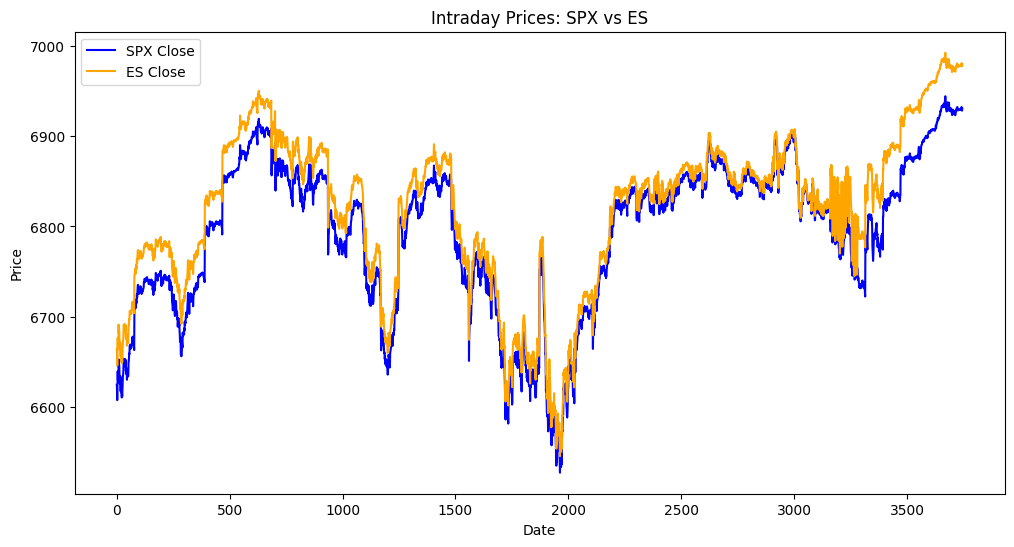

In [128]:
# Exploratory plot of 1st (SPX) and 3rd (ES) colummns
plt.figure(figsize=(12,6))
plt.plot(intraday_data_yf_v2.iloc[:,1], label='SPX Close', color='blue')
plt.plot(intraday_data_yf_v2.iloc[:,3], label='ES Close', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Intraday Prices: SPX vs ES')
plt.legend()
plt.show()


### Merge with the all the separate yahoo finance data series on time 

In [129]:
# Merge the intraday_data with sp500_intraday on the time column, using a right join
# which means we keep all rows from sp500_intraday, but only those rows from intraday_data that have matching time values
intraday_data = pd.merge(intraday_data_yf_v2, sp500_intraday_returns, on='time', how='right')

In [130]:
intraday_data

,time,spx_level_yf,spy_level_yf,es_level_yf,spx_level,spy_level,spx_period_return,spx_total_return,spy_period_return,spy_total_return
0,2025-11-28 09:30:00,6829.910156,681.489990,6840.00,6825.28,679.06,NaN,NaN,NaN,NaN
1,2025-11-28 09:40:00,6826.770020,681.270020,6838.50,6830.12,679.52,0.000709,0.000709,0.000677,0.000677
2,2025-11-28 09:50:00,6828.250000,681.304993,6838.75,6826.03,679.23,-0.000599,0.000110,-0.000427,0.000250
3,2025-11-28 10:00:00,6826.049805,681.229919,6838.25,6829.63,679.48,0.000527,0.000637,0.000368,0.000619
4,2025-11-28 10:10:00,6831.149902,681.630005,6842.50,6833.94,679.99,0.000631,0.001268,0.000750,0.001370
...,...,...,...,...,...,...,...,...,...,...
762,2025-12-26 15:20:00,6930.140137,690.200012,6978.50,6930.09,690.20,0.000120,0.015239,0.000058,0.016405
763,2025-12-26 15:30:00,6930.509766,690.250000,6978.75,6931.67,690.38,0.000228,0.015467,0.000261,0.016670
764,2025-12-26 15:40:00,6932.500000,690.450012,6981.25,6931.01,690.31,-0.000095,0.015372,-0.000101,0.016567
765,2025-12-26 15:50:00,6928.459961,690.070007,6977.75,6930.52,690.25,-0.000071,0.015301,-0.000087,0.016479


## EDA Visualisations of Price / Index Level Data

In [131]:
# set a temporary dataframe that does not have any of the rows with NaN values in either column
# order in ascending time order just to be sure
levels_df = intraday_data.copy().sort_values(by='time', ascending=True)

levels_df 

,time,spx_level_yf,spy_level_yf,es_level_yf,spx_level,spy_level,spx_period_return,spx_total_return,spy_period_return,spy_total_return
0,2025-11-28 09:30:00,6829.910156,681.489990,6840.00,6825.28,679.06,NaN,NaN,NaN,NaN
1,2025-11-28 09:40:00,6826.770020,681.270020,6838.50,6830.12,679.52,0.000709,0.000709,0.000677,0.000677
2,2025-11-28 09:50:00,6828.250000,681.304993,6838.75,6826.03,679.23,-0.000599,0.000110,-0.000427,0.000250
3,2025-11-28 10:00:00,6826.049805,681.229919,6838.25,6829.63,679.48,0.000527,0.000637,0.000368,0.000619
4,2025-11-28 10:10:00,6831.149902,681.630005,6842.50,6833.94,679.99,0.000631,0.001268,0.000750,0.001370
...,...,...,...,...,...,...,...,...,...,...
762,2025-12-26 15:20:00,6930.140137,690.200012,6978.50,6930.09,690.20,0.000120,0.015239,0.000058,0.016405
763,2025-12-26 15:30:00,6930.509766,690.250000,6978.75,6931.67,690.38,0.000228,0.015467,0.000261,0.016670
764,2025-12-26 15:40:00,6932.500000,690.450012,6981.25,6931.01,690.31,-0.000095,0.015372,-0.000101,0.016567
765,2025-12-26 15:50:00,6928.459961,690.070007,6977.75,6930.52,690.25,-0.000071,0.015301,-0.000087,0.016479


### Pre-Plotting Cleaning

#### Change to Dataframe Format

In [132]:
levels_df.index

RangeIndex(start=0, stop=767, step=1)

In [133]:
# Melt the dataframe to long format for plotting
# get the subset we want to plot:
#level_plot_df = levels_df[['time','spx_total_return','spy_total_return']]
level_plot_df = levels_df.copy().drop(columns = ['spy_level','spy_level_yf'])
level_plot_df['second_index'] = levels_df.index
# for each date, we have 1 value each for each of the total returns columns
level_plot_df = level_plot_df.melt(
    id_vars=['time','second_index'],
    # choose the value variables to be all the column names that end with 'level'
    value_vars= [ col for col in level_plot_df.columns if 'level' in col],
    value_name='level'
)

# drop the nan values, which will be for the first day
level_plot_df = level_plot_df.dropna(subset=['level'])

# add a time label column that is just the datetime time column as an object
level_plot_df['time_label'] = level_plot_df['time'].astype(object)


level_plot_df

,time,second_index,variable,level,time_label
0,2025-11-28 09:30:00,0,spx_level_yf,6829.910156,2025-11-28 09:30:00
1,2025-11-28 09:40:00,1,spx_level_yf,6826.770020,2025-11-28 09:40:00
2,2025-11-28 09:50:00,2,spx_level_yf,6828.250000,2025-11-28 09:50:00
3,2025-11-28 10:00:00,3,spx_level_yf,6826.049805,2025-11-28 10:00:00
4,2025-11-28 10:10:00,4,spx_level_yf,6831.149902,2025-11-28 10:10:00
...,...,...,...,...,...
2296,2025-12-26 15:20:00,762,spx_level,6930.090000,2025-12-26 15:20:00
2297,2025-12-26 15:30:00,763,spx_level,6931.670000,2025-12-26 15:30:00
2298,2025-12-26 15:40:00,764,spx_level,6931.010000,2025-12-26 15:40:00
2299,2025-12-26 15:50:00,765,spx_level,6930.520000,2025-12-26 15:50:00


#### Add a Label Mapping for Each Type of Return

In [134]:
# Get the unique return types from the melted DataFrame
series_types = level_plot_df['variable'].dropna().unique()

# Create a label mapping that maps the return types to more compact labels
label_mapping = {
    'spx_level_yf': 'S&P 500 Index \n Level YF',
    'spy_level_yf': 'SPY ETF \n Price YF',
    'es_level_yf': 'ES Futures \n Settlement YF',
    'spx_level': 'S&P 500 Index \n Level CIQ',
    'spy_level': 'SPY ETF \n Price CIQ'
}

#### Add a Colour Mapping for Each type of Return

In [135]:
# Create a mapping for colors for each series_types using a yellow to red gradient

# Use matplotlib's colormap to generate a yellow-to-red spectrum
cmap = plt.get_cmap('autumn')  # yellow to red
colors = [mcolors.to_hex(cmap(i / max(1, (len(series_types) - 1)))) for i in range(len(series_types))]
# Map each return_type to a color
color_map = dict(zip(series_types, colors))

In [136]:
color_map

{'spx_level_yf': '#ff0000', 'es_level_yf': '#ff8000', 'spx_level': '#ffff00'}

### X Series Labels

In [137]:
# 1. Select relevant columns and remove duplicates
label_df = level_plot_df[['time','second_index']].drop_duplicates(subset = ['second_index'])

# 2. Choose evenly spaced rows to get at most 10 unique ticks
n_ticks = min(10, len(label_df))
step = max(1, len(label_df) // n_ticks)
label_df_filtered = label_df.iloc[::step].head(n_ticks)

# 3. Extract breaks and labels
time_breaks = label_df_filtered['second_index'].tolist()
time_labels = label_df_filtered['time'].tolist()

In [138]:
time_breaks[:5]

[0, 79, 159, 237, 315]

### Plot the Prices and Index Levels of Each Series and Data Source

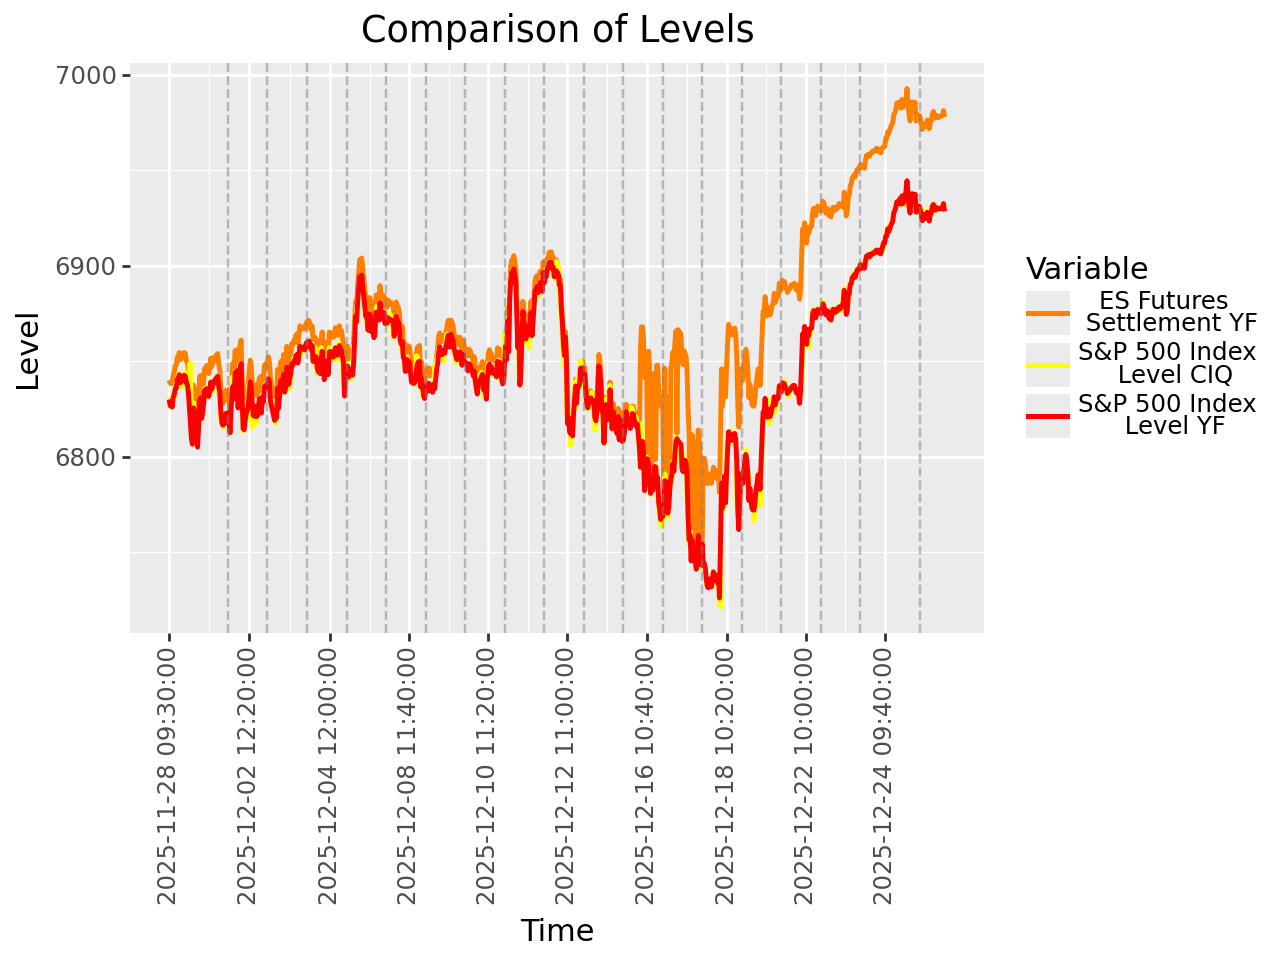

In [143]:
### Plot Each Series On One Plot

def plot_series(
    plot_df=plot_df,
    y='value',
    plot_title='Values Over Time',
    y_title='Value',
    display_plot=True
):
    # suppress missing value warnings
    warnings.filterwarnings('ignore', category=PlotnineWarning)

    # Use global color_map, commodity_labels, date_breaks, date_labels
    # Create the plot using plotnine (ggplot-style)
    plot = (
        # Set up the basic plot with aesthetics: x=time, y=selected y, color by return_type
        ggplot(plot_df, aes(x=plot_df['second_index'], y=y, color='variable')) +
        # Draw lines for each return_type
        geom_line(size=1) +
        # Manually set colors for each return_type using the color_map and set legend labels
        scale_color_manual(values=color_map, labels=label_mapping) +
        # Set plot and axis labels
        labs(
            title=plot_title,
            x='Time',
            y=y_title,
            color='Variable'
        ) +
        scale_x_continuous(breaks=time_breaks, labels=time_labels) +
        
        # add a vertical line at each daily close (16:00 hours)
        geom_vline(xintercept=[i for i, time in enumerate(plot_df['time'][:plot_df['second_index'].max()]) if time.hour == 15 and time.minute == 50],
                   color='grey', linetype='dashed', alpha=0.5) +
      
        # Customize theme: rotate x labels, move legend, center title
        theme(
            axis_text_x=element_text(rotation=90, ha='center'),
            legend_position='right',
            plot_title=element_text(ha='center')
        ) +
        # Remove linetype guide from legend
        guides(linetype=None)
    )

    # Save plot to file
    fig_path = f"../docs/figures/{plot_title}.png"
    plot.save(fig_path, width=10, height=6, dpi=300)

    # Display plot if requested
    if display_plot:
        display(plot)

    return plot

plot_1 = plot_series(
    plot_df=level_plot_df,
    y='level',
    plot_title='Comparison of Levels',
    y_title='Level',
    display_plot=True
)


### Mimic with Plotly

In [159]:
# define columns of interest
cols_of_interest = [col for col in levels_df.columns if 'spx_level' in col or 'es_level' in col]
level_plotly_df = levels_df.copy()[['time'] + cols_of_interest]
level_plotly_df['second_index'] = level_plotly_df.index

In [160]:
level_plotly_df

,time,spx_level_yf,es_level_yf,spx_level,second_index
0,2025-11-28 09:30:00,6829.910156,6840.00,6825.28,0
1,2025-11-28 09:40:00,6826.770020,6838.50,6830.12,1
2,2025-11-28 09:50:00,6828.250000,6838.75,6826.03,2
3,2025-11-28 10:00:00,6826.049805,6838.25,6829.63,3
4,2025-11-28 10:10:00,6831.149902,6842.50,6833.94,4
...,...,...,...,...,...
762,2025-12-26 15:20:00,6930.140137,6978.50,6930.09,762
763,2025-12-26 15:30:00,6930.509766,6978.75,6931.67,763
764,2025-12-26 15:40:00,6932.500000,6981.25,6931.01,764
765,2025-12-26 15:50:00,6928.459961,6977.75,6930.52,765


In [195]:
app = Dash(__name__)

num_marks = 20  # How many marks I want to have
mark_positions = np.linspace(0, len(level_plotly_df)-1, num_marks, dtype=int)

# Create app layout
app.layout = html.Div([
    html.H3('Comparison of Levels'),
    # Leave some spaces before graph
    html.Br(),
    html.Br(),
    html.Br(),
    html.Br(),

    # RangeSlider for time selection
    dcc.RangeSlider(
        id='time-range-slider',
        min=0,
        max=len(level_plotly_df)-1,
        marks={
            int(pos): {
                'label': level_plotly_df['time'].iloc[pos].strftime('%y-%m-%d %H:%M'),
                'style': {
                    'transform': 'rotate(-90deg)',
                    'transformOrigin': 'top left',  # Pivot from top left
                    'whiteSpace': 'nowrap',
                    'textAlign': 'center',  # Align text to center before rotation
                    'marginTop': '-20px',  # Push up away from slider if needed
                    'marginLeft': '-8px'
                }
            }
            for pos in mark_positions
        },

        value=[0, len(level_plotly_df)-1],  # Initial full range
        tooltip={"placement": "bottom", "always_visible": True}
    ),
    
    # Leave some spaces before graph
    html.Br(),
    
    # Graph component
    dcc.Graph(id='level-plot')
])

# Callback to update plot when slider changes
@app.callback(
    Output('level-plot', 'figure'),
    Input('time-range-slider', 'value')
)
def update_plot(time_range):
    # Extract selected range
    start_idx, end_idx = time_range
    
    # Filter data to selected range
    filtered_df = level_plotly_df.iloc[start_idx:end_idx+1].copy()
    
    # Create 20 evenly spaced tick position
    tick_positions = np.linspace(0, len(filtered_df)-1, 20, dtype=int)
    
    # Reindex each variable to 100 at the start of selected range
    fig = go.Figure()
    
    for col in cols_of_interest:
        var_data = filtered_df[col]
        
        # Normalize to 100 at first point in selected range
        first_value = var_data.iloc[0]
        normalized = (var_data / first_value) * 100
        
        fig.add_trace(go.Scatter(
            x=filtered_df['second_index'],
            y=normalized,
            mode='lines',
            name=col,
            line=dict(width=2)
        ))
    # Add vertical lines at 15:50 (market close)
    close_times = filtered_df[
        (filtered_df['time'].dt.hour == 15) & 
        (filtered_df['time'].dt.minute == 50)
    ]

    for idx, row in close_times.iterrows():
        fig.add_vline(
            x=row['second_index'],
            line=dict(color='grey', dash='dash', width=1),
            opacity=0.5
        )
    
    fig.update_layout(
        title='Levels Reindexed to 100',
        xaxis_title='Time',
        yaxis_title='Level (Base 100)',
        hovermode='x unified',
        xaxis=dict(
            tickmode='array',
            tickvals=[filtered_df['second_index'].iloc[i] for i in tick_positions],
            ticktext=[filtered_df['time'].iloc[i].strftime('%y-%m-%d %H:%M') for i in tick_positions],
            tickangle=-90  # Rotate tick labels 90 degrees
        )
    )
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=8050)

## Back-Test Volatility Control Strategy

### Import the Returns Data

In [16]:

# data for just google (default)
#returns = pd.read_excel('../data/GOOG_ret.xlsx')

# data for just S&P 500
returns = pd.read_excel('../data/sp500_interday_returns.xlsx')


#### Initial Cleaning

In [17]:
# change the column names to 'time' and 'return'
returns.columns = ['time', 'return']

# convert the time column to datetime format
returns['time'] = pd.to_datetime(returns['time'], format='%d-%b-%Y', errors='coerce')

# eliminate any rows where return is 0 or NaN
returns = returns[(returns['return'] != 0) & (returns['return'].notna())]

# eliminate the first 2520 observations, which are the first 10 years of data,
#  only ever used for estimation and never forecasting
returns = returns.iloc[2520:].reset_index(drop=True)

# Add a time_label column for plotting, which takes the year, month and day in YY-MM-DD format
returns['time_label'] = returns['time'].dt.strftime('%y-%m-%d')

### Import the Forecasted Quantiles Data

In [18]:
# Load the quantiles data from the MATLAB file
#data = loadmat('../data/goog.mat') # load in the data for google

#data = loadmat('../data/sp500_interday.mat') # load in the data for S&P 500

# load in the forecast quantiles for the s&p500 data
data = loadmat('../data/q_minus_all_BJSAV_5_norm_SP500.mat')

q_minus = data['q_minus_all_select'] # extract the 3D matrix, or rather, array of 2D matrices for the quantiles
# the 3rd dimension is the quantile index, so q_minus[:,:,0] is the first quantile (the lowest pr), q_minus[:,:,1] is the second quantile, etc.

In [19]:
q_minus.shape, returns.shape

((3766, 8), (3766, 3))

In [20]:
returns.tail()

,time,return,time_label
3761,2024-12-24,0.010982,24-12-24
3762,2024-12-26,-0.000406,24-12-26
3763,2024-12-27,-0.011117,24-12-27
3764,2024-12-30,-0.010760,24-12-30
3765,2024-12-31,-0.004294,24-12-31


### Get the Forecast Quantiles

In [ ]:
# Take mean across iterations for *all* quantiles
#posterior_means = q_minus.mean(axis=0)   # shape (4033, 8)

# The Posterior Means were already calculated in the MATLAB file, so we can just use them directly
quantile_forecasts = q_minus

# Wrap in DataFrame
quantile_forecasts_df = pd.DataFrame(
    quantile_forecasts,
    columns=[f"q_{i+1}" for i in range(quantile_forecasts.shape[1])]
)

print(quantile_forecasts_df.head())

        q_1       q_2       q_3       q_4       q_5       q_6       q_7  \
0 -0.000766 -0.001569 -0.002505 -0.003777 -0.005325 -0.006875 -0.008647   
1 -0.000841 -0.001709 -0.002698 -0.004041 -0.005679 -0.007323 -0.009215   
2 -0.000795 -0.001609 -0.002544 -0.003845 -0.005431 -0.007004 -0.008828   
3 -0.000934 -0.001876 -0.002928 -0.004360 -0.006114 -0.007875 -0.009918   
4 -0.001061 -0.002120 -0.003277 -0.004836 -0.006750 -0.008690 -0.010937   

        q_8  
0 -0.011634  
1 -0.012363  
2 -0.011878  
3 -0.013269  
4 -0.014573  


### Merge the Quantiles with the Returns Data

Here, we also select only a specified date range for easier visualisation

In [22]:
# merge with the returns Dataframe
merged_returns = returns.merge(quantile_forecasts_df, left_index=True, right_index=True)

# # filter out the first 100 observations
#merged_returns = merged_returns.iloc[100:]

# reverse the order of the non-time columns so that we go from q_8 to q_1 and then return
#merged_returns = merged_returns[['time', 'time_label'] + [f'q_{i+1}' for i in range(7, -1, -1)] + ['return']]

In [23]:
merged_returns.tail()

,time,return,time_label,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8
3761,2024-12-24,0.010982,24-12-24,-0.001017,-0.002016,-0.003111,-0.004428,-0.006024,-0.008001,-0.010616,-0.015215
3762,2024-12-26,-0.000406,24-12-26,-0.001057,-0.002096,-0.003236,-0.004605,-0.006263,-0.008314,-0.011021,-0.015769
3763,2024-12-27,-0.011117,24-12-27,-0.000945,-0.001866,-0.002878,-0.004109,-0.005627,-0.007516,-0.010025,-0.014490
3764,2024-12-30,-0.010760,24-12-30,-0.001022,-0.002022,-0.003120,-0.004448,-0.006070,-0.008082,-0.010742,-0.015439
3765,2024-12-31,-0.004294,24-12-31,-0.001079,-0.002136,-0.003298,-0.004699,-0.006402,-0.008509,-0.011290,-0.016173


### Calculate Target Weights Based on Forecast Quantiles

Consider a simple representative portfolio with some weight in a market index and some weight in cash. We back-test the performance of index strategies where the index portfolio is rebalanced daily, and the weights are adjusted based on the forecasted quantiles of returns.

For comparability to volatility targeting, we similarly dynamically adjust the weights in the market index so as to maintain target forecasted quantiles. When the forecasted lower/left tail quantiles of returns on the carrying value of the portfolio are below the target/are more negative, we reduce the weights in the market index until the forecasted quantile of returns returns to target. Likewise, when the forecasted upper/right tail quantiles are above the target, we increase the weights in the market index.

By setting a target step-ahead quantile at probability level p% to not fall below a certain level, r%, we effectively aim for the portfolio to have no more than a p% probability of seeing a drawdown of k% or more over the next step-ahead period. This can then aggregate to a longer period, such as over the next quarter or year. For reference, if we set p = 5.56%, and r = 0.63%, then we are aiming for the portfolio to have no more than a 5.56% probability of seeing a drawdown of 0.63% or more over the next step-ahead period, and in turn, no more than a 5.56% probability of seeing a drawdown of 5% or more over the next quarter.

In [24]:
# add a mapping of quantile numbers to quantile levels
# 8 to 1 map to 0.0556, 0.1111, 0.1667, 0.2222, 0.2778, 0.3333, 0.3889, 0.4444 respectively
quantile_level_map = {
    1: 0.4444,
    2: 0.3889,
    3: 0.3333,
    4: 0.2778,
    5: 0.2222,
    6: 0.1667,
    7: 0.1111,
    8: 0.0556
}

In [25]:
# Set maximum drawdown/quantile target
r = 0.0063

# Note that the target probability level will be given by the quantile forecast that we compare this to, in this case q_8

# define a function calc_targ_weight that calculates the target weight in the market index based on the quantile forecast
# this takes as input a the forecast quantile we are comparing and the maximum drawdown/quantile target
def calc_targ_weight(q_forecast: float, r: float, spec: int = 2) -> float:
    """
    Calculate the target weight in the market index based on the quantile forecast.
    
    Args:
        q_forecast (float): The forecasted quantile value.
        r (float): The maximum drawdown/quantile target.
        
    Returns:
        float: The target weight in the market index.
    """
    if spec == 1:
        # For the first specification, the weight is set to 1 when the quantile forecast is above the target
        if q_forecast >= -r:
            w_targ = 1
        else:
            # If the quantile forecast is below the target, we set the weight to 0
            w_targ = 0
        return w_targ
    if spec == 2:
        # For the second specification, the weight changes linearly with the quantile forecast
        w_targ = max(min(1, (-r / q_forecast))   ,0)

    return w_targ





#### Apply this to the Merged Returns Data

In [26]:
# A function that calculates the target weights and actual weights for each period
# based on the quantile forecasts and the maximum drawdown/quantile target
def add_weights(
    df: pd.DataFrame,
    r: float = 0.0063,
    spec: int = 2, 
    q_level: int = 8
    ) -> pd.DataFrame:
    """
    Calculate target weights and actual weights based on quantile forecasts.
    
    Args:
        df (pd.DataFrame): DataFrame containing quantile forecasts and returns.
        r (float): Maximum drawdown/quantile target.
        spec (int): Specification for weight calculation (1 or 2).
        
    Returns:
        pd.DataFrame: DataFrame with added target and actual weights.
    """
    df = df.copy()  # Prevent modifying the original DataFrame
    # Calculate target weights based on the quantile forecast for q_8
    df['target_weight'] = df[f'q_{q_level}'].apply(lambda x: calc_targ_weight(x, r, spec))
    
    # Create an actual_weight column that is the target weight column shifted by one row
    # this is to reflect a 1-day trading delay
    df['actual_weight'] = df['target_weight'].shift(1)

    # Now calculate the actual, risk control returns based on the actual weight
    df['risk_control_return'] = df['return'] * df['actual_weight']
    
    return df


In [27]:
# More efficient - Direct vectorized calculation for spec=2
#merged_returns['target_weight'] = np.maximum(np.minimum(1, -r / merged_returns['q_7']),0) # makes sure the weight is between 0 and 1

# OPTION 2: Alternative using pandas clip method (also vectorized)
# merged_returns['w_targ'] = (r / merged_returns['q_8']).clip(upper=1)

# OPTION 3: If you need to handle different specs, use numpy.where for vectorized conditionals
# For spec=1: merged_returns['w_targ'] = np.where(merged_returns['q_8'] >= -r, 1, 0)

# The original apply method (keep for reference but commented out)
# merged_returns['w_targ'] = merged_returns['q_8'].apply(lambda x: calc_targ_weight(x, r, spec=2))

### Calculate 'Actual' Weights to Reflect Trading Delays

In the above, we created a index_weight column that is the target weight column shifted by one row this is to reflect a 1-day trading delay (we only know the target weight at the beginning of the day that follows the last day of the estimation window, because only then do we know the confirmed closing price of the last day).

For liquidity reasons, we only trade once a day, at the end of the day, and so even though we know the target weight at the beginning of the day, we only trade at the end of that day.

### Calculate Total Returns

Note that this is done over a specified window of one's choosing, by default, we zoom in on the GFC period, but this can be changed by modifying the `start_date` and `end_date` variables.

In [28]:
def calc_total_returns(merged_df, start_date=None, end_date=None, return_df=True):
    """
    Calculate total and S&P500 risk control returns for a specified window and filter quantile columns.

    Args:
        merged_df (pd.DataFrame): DataFrame containing returns and quantiles.
        start_date (str or None): Start date for the window (inclusive), format 'YYYY-MM-DD'.
        end_date (str or None): End date for the window (inclusive), format 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame or dict: Modified DataFrame with total returns and selected columns, or statistics dict.
    """
    # If start_date or end_date is None, use the full DataFrame
    if start_date is None or end_date is None:
        df = merged_df.copy()
    else:
        df = merged_df[(merged_df['time'] >= start_date) & (merged_df['time'] <= end_date)].copy()

    # Add a 'total_return' column which is the cumulative return under log returns for the chosen time window
    return_sum = df['return'].cumsum()
    df['total_return'] = np.exp(return_sum) - 1

    # Calculate the cumulative S&P500 risk control return
    risk_control_return_sum = df['risk_control_return'].cumsum()
    df['total_risk_control_return'] = np.exp(risk_control_return_sum) - 1

    # Drop the first row, as it has NaN values for actual_weight and risk_control_return
    # this is needed because else the quantiles won't calculate correctly for the first year
    #  (where the first total return row is NaN)
    df = df.dropna(subset=['actual_weight', 'risk_control_return'])

    if return_df:
        # Get just the weights columns to a separate DataFrame if needed outside (not returned here)
        weights_df = df[['time', 'time_label', 'target_weight', 'actual_weight']].copy()

        # Filter out the q_1, q_2, q_3, q_5 and q_6 columns, and set the desired order of columns
        df = df[['time', 'time_label', 'total_return', 'total_risk_control_return', 'return'] + [f'q_{i}' for i in [1,4,7,8]]]

        return df, weights_df

    else:
        # get the total return over the whole period for the S&P500 and the S&P500 risk control
        S_and_P500_total_return = df['total_return'].iloc[-1]
        S_and_P500_risk_control_total_return = df['total_risk_control_return'].iloc[-1]

        # Annualize each of these returns under log returns
        S_and_P500_total_return_annualized = np.exp(df['return'].mean() * 252) - 1
        S_and_P500_risk_control_total_return_annualized = np.exp(df['risk_control_return'].mean() * 252) - 1

        # calculate the annualized volatility of the different returns
        S_and_P500_annualized_volatility = df['return'].std() * np.sqrt(252)
        S_and_P500_risk_control_annualized_volatility = df['risk_control_return'].std() * np.sqrt(252)

        # calculate the annualized Sharpe ratio for both the total return and the risk control return
        S_and_P500_annualized_sharpe_ratio = S_and_P500_total_return_annualized / S_and_P500_annualized_volatility
        S_and_P500_risk_control_annualized_sharpe_ratio = S_and_P500_risk_control_total_return_annualized / S_and_P500_risk_control_annualized_volatility

        # Calculate the observed quantile levels (1% best (99% worst) returns, then 5%, 10% and 20%)
        quantile_levels = {
            'q_1': np.quantile(df['return'], 0.01),
            'q_5': np.quantile(df['return'], 0.05),
            'q_10': np.quantile(df['return'], 0.10),
            'q_20': np.quantile(df['return'], 0.20)
        }

        risk_control_quantile_levels = {
            'q_1': np.quantile(df['risk_control_return'], 0.01),
            'q_5': np.quantile(df['risk_control_return'], 0.05),
            'q_10': np.quantile(df['risk_control_return'], 0.10),
            'q_20': np.quantile(df['risk_control_return'], 0.20)
        }

        # Build the result dictionary with new naming conventions
        result = {
            'S&P500_total_return': float(S_and_P500_total_return),
            'S&P500_risk_control_total_return': float(S_and_P500_risk_control_total_return),
            'S&P500_annualized_return': float(S_and_P500_total_return_annualized),
            'S&P500_risk_control_annualized_return': float(S_and_P500_risk_control_total_return_annualized),
            'S&P500_annualized_volatility': float(S_and_P500_annualized_volatility),
            'S&P500_risk_control_annualized_volatility': float(S_and_P500_risk_control_annualized_volatility),
            'S&P500_annualized_sharpe_ratio': float(S_and_P500_annualized_sharpe_ratio),
            'S&P500_risk_control_annualized_sharpe_ratio': float(S_and_P500_risk_control_annualized_sharpe_ratio),
        }
        # Add quantile levels as top-level keys
        for k in quantile_levels.keys():
            quantile_num = k.split('_')[1]
            result[f'S&P500_{quantile_num}%_Lowest_Return'] = float(quantile_levels[k])
            result[f'S&P500_risk_control_{quantile_num}%_Lowest_Return'] = float(risk_control_quantile_levels[k])
        return result


## Compare Performance of Different Srategies

#### Create a Function to Save the Performance Summary Statistics to Excel Nicely

In [29]:
def save_with_bold_highlights(summary_stats, filename):
    # Identify metric pairs (assume every two columns after the first two are a pair)
    cols = summary_stats.columns.tolist()
    pairs = [(cols[i], cols[i+1]) for i in range(2, len(cols), 2)]
    volatility_keywords = ['volatility']
    sharpe_keywords = ['sharpe']

    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        summary_stats.to_excel(writer, index=False)
        workbook  = writer.book
        worksheet = writer.sheets['Sheet1']
        bold = workbook.add_format({'bold': True})

        for row in range(1, len(summary_stats)+1):  # +1 for header
            for col1, col2 in pairs:
                idx1 = cols.index(col1)
                idx2 = cols.index(col2)
                val1 = summary_stats.iloc[row-1, idx1]
                val2 = summary_stats.iloc[row-1, idx2]
                metric = col1.lower()

                # For volatility, lower is better
                if any(key in metric for key in volatility_keywords):
                    if val1 < val2:
                        worksheet.write(row, idx1, val1, bold)
                    elif val2 < val1:
                        worksheet.write(row, idx2, val2, bold)
                # For Sharpe, ignore if both negative
                elif any(key in metric for key in sharpe_keywords):
                    if val1 >= 0 and val1 > val2:
                        worksheet.write(row, idx1, val1, bold)
                    elif val2 >= 0 and val2 > val1:
                        worksheet.write(row, idx2, val2, bold)
                # For all other metrics, higher is better
                else:
                    if val1 > val2:
                        worksheet.write(row, idx1, val1, bold)
                    elif val2 > val1:
                        worksheet.write(row, idx2, val2, bold)

        # writer.save()

#### Create a Function to Calculate Performance Metrics

In [30]:
def get_performance_metrics(df, save = False):
    """
    Calculate performance summary statistics for each strategy and time window.

    Args:
        df (pd.DataFrame): DataFrame containing returns and quantiles.

    Returns:
        pd.DataFrame: Summary statistics DataFrame for each time window.
    """
    # Initialise an empty dataframe to store the summary statistics for each time window
    
    # Define the time windows for backtesting as the start and end of each year for the
    #  last 10 years up to the last available date in the dataset
    last_date = df['time'].max().date()  # Get the last date in the dataset
    first_date = df['time'].min().date()  # Get the first date in the dataset
    # Start from 20 years ago, or as far as the data goes back, whichever is later
    start_year = max(last_date.year - 20, first_date.year)

    # Collect results in a list of dicts, then create DataFrame at the end
    stats_list = []
    for year in range(start_year, last_date.year + 1):
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        stats = calc_total_returns(df, start_date=start_date, end_date=end_date, return_df=False)
        stats_list.append({
            'start_date': start_date,
            'end_date': end_date,
            **stats
        })

    # Add YTD (Year-To-Date) window
    ytd_start = f"{last_date.year}-01-01"
    ytd_end = str(last_date)
    stats = calc_total_returns(df, start_date=ytd_start, end_date=ytd_end, return_df=False)
    stats_list.append({
        'start_date': ytd_start,
        'end_date': ytd_end,
        **stats
    })

    # Add last 3, 5, and 10 year windows (up to and including last_date)
    for window in [3, 5, 10]:
        window_start_year = max(last_date.year - window + 1, first_date.year)
        window_start = f"{window_start_year}-01-01"
        window_end = str(last_date)
        stats = calc_total_returns(df, start_date=window_start, end_date=window_end, return_df=False)
        stats_list.append({
            'start_date': window_start,
            'end_date': window_end,
            **stats
        })

    # Convert the list of dicts to a DataFrame
    summary_stats = pd.DataFrame(stats_list)

    # convert every other column besides the first two (date column) to float 
    for col in summary_stats.columns[2:]:
        if col not in ['start_date', 'end_date']:
            summary_stats[col] = summary_stats[col].astype(float)
            # Round the summary statistics to 4 decimal places for better readability
            summary_stats[col] = summary_stats[col].round(4)
    
    

    # Convert the column names to title case and replace underscores with spaces
    summary_stats.columns = [col.replace('_', ' ').title() for col in summary_stats.columns]

    if save:
        # Save the summary statistics DataFrame to an excel file in the data directory
        summary_stats.to_excel("../data/summary_stats.xlsx", index=False)

    # Display the summary statistics DataFrame
    #display(summary_stats.tail(8))

    return summary_stats


### Get the Weights and Returns for Different Rebalancing Rules

In [31]:
strat_1 = add_weights(merged_returns, r=0.01, spec=2, q_level=7)
strat_2 = add_weights(merged_returns, r=0.01, spec=2, q_level=8)
strat_3 = add_weights(merged_returns, r=0.02, spec=1, q_level=8)

In [ ]:
# Save the Results of the one of the startegies
perf_1 = get_performance_metrics(strat_1)



In [68]:
# Compare the performance of different strategies over same period (last 10 years)
pd.concat([
    get_performance_metrics(strat_1).tail(1).assign(strategy='spec2_q8'),
    get_performance_metrics(strat_2).tail(1).assign(strategy='spec1_q8'),
    get_performance_metrics(strat_3).tail(1).assign(strategy='spec2_q7')
], ignore_index=True)

,Start Date,End Date,S&P500 Total Return,S&P500 Risk Control Total Return,S&P500 Annualized Return,S&P500 Risk Control Annualized Return,S&P500 Annualized Volatility,S&P500 Risk Control Annualized Volatility,S&P500 Annualized Sharpe Ratio,S&P500 Risk Control Annualized Sharpe Ratio,S&P500 1% Lowest Return,S&P500 Risk Control 1% Lowest Return,S&P500 5% Lowest Return,S&P500 Risk Control 5% Lowest Return,S&P500 10% Lowest Return,S&P500 Risk Control 10% Lowest Return,S&P500 20% Lowest Return,S&P500 Risk Control 20% Lowest Return,strategy
0,2015-01-01,2024-12-31,1.8567,1.5185,0.1109,0.0970,0.1789,0.1408,0.6199,0.6885,-0.033,-0.0280,-0.017,-0.0148,-0.0111,-0.0096,-0.0057,-0.0053,spec2_q8
1,2015-01-01,2024-12-31,1.8567,0.7839,0.1109,0.0597,0.1789,0.0955,0.6199,0.6255,-0.033,-0.0183,-0.017,-0.0099,-0.0111,-0.0069,-0.0057,-0.0036,spec1_q8
2,2015-01-01,2024-12-31,1.8567,0.7359,0.1109,0.0568,0.1789,0.1200,0.6199,0.4736,-0.033,-0.0248,-0.017,-0.0130,-0.0111,-0.0077,-0.0057,-0.0032,spec2_q7


### Find the Best Performing Strategy

We begin with a baseline row, which is just the s&p 500 raw performance

In [ ]:
# To comapre the performance of strategies, we will prioritise those metrics over the last 10 years,
# which is the last row of a given performance DataFrame
# to begin with, we need everything but the first 4 columns, which are the start and end dates
# and the total return (non-annualised) for the S&P 500 and the risk control strategy
# and additionally, only the metrics for s&p500 without the risk control strategy, which is every odd
# column starting from the 5th column (index 4). THIS IS TO SERVE AS A BASELINE FOR COMPARISON

# here, we extract a 1 row dataframe with the last row of the performance DataFrame
# but every second column starting from the 5th column (index 4)
# this is to get the S&P 500 performance metrics as a baseline for comparison

baseline_row = perf_1.iloc[-1, 4::2].to_frame().T.reset_index(drop=True)

# convert everything to float
baseline_row = baseline_row.astype(float)

# add the first column as a strategy name, this one is S&P500 (Baseline)
baseline_row.insert(0, 'Strategy', 'S&P500 (Baseline)')

# add a second, third and fourth column with the 
# quantile level, the maximum drawdown and the specification (these should be empty
# since this is the baseline)
baseline_row.insert(1, 'Quantile Level', np.nan)  # q_level
baseline_row.insert(2, 'Maximum Drawdown', np.nan)  # r
baseline_row.insert(3, 'Specification', np.nan)  # spec

#rename the columns to remove the 'S&P500 ' prefix
baseline_row.columns = [col.replace('S&P500 ', '') for col in baseline_row.columns]

# Move annualised sharpe ratio and annulaised returns to  be the first columns
# this is to make it easier to compare the strategies
priority_cols = ['Annualized Sharpe Ratio', 'Annualized Return']
baseline_row = baseline_row[priority_cols + 
                        [col for col in baseline_row.columns if col not in priority_cols]]

# baseline_row

,Annualized Sharpe Ratio,Annualized Return,Strategy,Quantile Level,Maximum Drawdown,Specification,Annualized Volatility,1% Lowest Return,5% Lowest Return,10% Lowest Return,20% Lowest Return
0,0.6199,0.1109,S&P500 (Baseline),NaN,NaN,NaN,0.1789,-0.033,-0.017,-0.0111,-0.0057


#### Create a Function that Extracts the Relevant (10-year) Performance Metrics

In [35]:
# Here, we define a function that takes as input a performance DataFrame 
# and returns a DataFrame with the last row and only those metrics corresponding to the strategy
def get_strategy_performance_row(perf_df, strategy_name, q_level=8, r=0.01, spec=2):
    """
    Extract the last row of performance metrics for a specific strategy.

    Args:
        perf_df (pd.DataFrame): DataFrame containing performance metrics.
        strategy_name (str): Name of the strategy to extract.

    Returns:
        pd.DataFrame: DataFrame with the last row of performance metrics for the specified strategy.
    """
    # Get the last row of the performance DataFrame, and select every second column 
    # starting from the 5th column (index 4), since these pertain to the metrics
    # for the S&P 500 with the risk control strategy
    last_row = perf_df.iloc[-1, 5::2].to_frame().T.reset_index(drop=True)
    
    # Convert everything to float
    last_row = last_row.astype(float)
    
    # Add the strategy name as the first column
    last_row.insert(0, 'Strategy', strategy_name)

    # add a second, third and fourth column with the 
    # quantile level, the maximum drawdown and the specification
    last_row.insert(1, 'Quantile Level', q_level)  # q_level
    last_row.insert(2, 'Maximum Drawdown', f'{r*100:.2f}%')  # r
    last_row.insert(3, 'Specification', spec)  # spec
    
    # Rename the columns to remove the 'S&P500 ' prefix
    last_row.columns = [col.replace('S&P500 Risk Control ', '') for col in last_row.columns]
    # Move annualised sharpe ratio and annulaised returns to  be the first columns
    # this is to make it easier to compare the strategies
    priority_cols = ['Annualized Sharpe Ratio', 'Annualized Return']
    last_row = last_row[priority_cols + 
                         [col for col in last_row.columns if col not in priority_cols]]

    
    
    
    return last_row

#### Iteratively Add to a Dataframe to Store Comparative Results

In [37]:
# define a function that creates a performance comparison DataFrame
def create_performance_comparison_df(r_list, q_level_list, spec_list, base_row = baseline_row, merged_df = merged_returns)   -> pd.DataFrame:
    """
    Create a DataFrame to compare the performance of different strategies.
    Args:
        base_row (pd.DataFrame): The baseline row to start the comparison with.
        r_list (list): list of maximum drawdown values for different strategies.
        q_level_list (list): list of quantile levels for different strategies.
        spec_list (list): list of specifications for different strategies.
    
    Returns:
        pd.DataFrame: DataFrame with the baseline row and space for additional strategies.
    """
    # initialise the dataframe to store the performance metrics for each strategy
    # as simply the baseline row
    performance_comparison_df = base_row.copy()

    # for each combination of r, q_level and spec, get the returns for the strategy
    # using the add_weights function.
    # then, using the output of that get performance metrics for the strategy using the 
    # get_performance_metrics function
    # and then get the last row of the performance DataFrame using the get_strategy_performance_row function
    for r, q_level, spec in zip(r_list, q_level_list, spec_list):
        # Get the quantile level as a percentage
        pct_level = quantile_level_map[q_level]
        # Get the strategy name based on the quantile level, maximum drawdown and specification
        strategy_name = f'{100*pct_level:.1f}% Worst Drawdown <= {r*100:.2f}%'
        
        # Get the strategy DataFrame with target and actual weights
        strategy_df = add_weights(merged_df, r=r, spec=spec, q_level=q_level)
        
        # Get the performance metrics for the strategy
        perf_metrics = get_performance_metrics(strategy_df, save=False)
        
        # Get the last row of performance metrics for the strategy
        last_row = get_strategy_performance_row(perf_metrics, strategy_name, q_level=q_level, r=r, spec=spec)
        
        # Append this row to the performance comparison DataFrame
        performance_comparison_df = pd.concat([performance_comparison_df, last_row], ignore_index=True)

    # Add a placeholder for future strategies
    return performance_comparison_df






In [39]:
# create a list of r, q_level and spec values to compare
r_list = [0.007, 0.008, 0.01, 0.012]
q_level_list = [7,8]
spec_list = [2]

# get all combinations of r, q_level and spec using itertools.product
r_list, q_level_list, spec_list = zip(*product(r_list, q_level_list, spec_list))
r_list

(0.007, 0.007, 0.008, 0.008, 0.01, 0.01, 0.012, 0.012)

In [40]:

#augment these so that we have a list of all combinations of r, q_level and spec
# get the performance comparison DataFrame
performance_comparison_df = create_performance_comparison_df(
    r_list=r_list,
    q_level_list=q_level_list,
    spec_list=spec_list,
    base_row=baseline_row,
    merged_df=merged_returns
)



In [41]:
# sort in decreasing order of annualized Sharpe ratio, followed by annualized return
performance_comparison_df = performance_comparison_df.sort_values(
    by=['Annualized Sharpe Ratio', 'Annualized Return'],ascending=False)

# Inspect the performance comparison DataFrame
performance_comparison_df

,Annualized Sharpe Ratio,Annualized Return,Strategy,Quantile Level,Maximum Drawdown,Specification,Annualized Volatility,1% Lowest Return,5% Lowest Return,10% Lowest Return,20% Lowest Return
7,0.6885,0.0970,11.1% Worst Drawdown <= 1.20%,7.0,1.20%,2.0,0.1408,-0.0280,-0.0148,-0.0096,-0.0053
5,0.6756,0.0861,11.1% Worst Drawdown <= 1.00%,7.0,1.00%,2.0,0.1274,-0.0248,-0.0138,-0.0091,-0.0047
8,0.6499,0.0726,5.6% Worst Drawdown <= 1.20%,8.0,1.20%,2.0,0.1117,-0.0212,-0.0118,-0.0081,-0.0041
3,0.6384,0.0699,11.1% Worst Drawdown <= 0.80%,7.0,0.80%,2.0,0.1096,-0.0204,-0.0115,-0.0079,-0.0040
6,0.6255,0.0597,5.6% Worst Drawdown <= 1.00%,8.0,1.00%,2.0,0.0955,-0.0183,-0.0099,-0.0069,-0.0036
1,0.6208,0.0606,11.1% Worst Drawdown <= 0.70%,7.0,0.70%,2.0,0.0976,-0.0183,-0.0102,-0.0071,-0.0037
0,0.6199,0.1109,S&P500 (Baseline),NaN,NaN,NaN,0.1789,-0.0330,-0.0170,-0.0111,-0.0057
4,0.6154,0.0471,5.6% Worst Drawdown <= 0.80%,8.0,0.80%,2.0,0.0766,-0.0146,-0.0079,-0.0055,-0.0029
2,0.6136,0.0411,5.6% Worst Drawdown <= 0.70%,8.0,0.70%,2.0,0.0670,-0.0128,-0.0069,-0.0048,-0.0025


In [70]:
# extract the parameters of the best strategy based on the annualized Sharpe ratio
# this means q_level, r and spec are the values under the 
# columns 'Quantile Level', 'Maximum Drawdown' and 'Specification' in the top row
best_strategy_params = performance_comparison_df.iloc[0][['Quantile Level', 'Maximum Drawdown', 'Specification']].to_dict()
best_q_level = int(best_strategy_params['Quantile Level'])
best_r = float(best_strategy_params['Maximum Drawdown'].strip('%')) / 100  # convert to float and divide by 100 to get the decimal value
best_spec = int(best_strategy_params['Specification'])

# Get the returns for the best strategy
strat_1 = add_weights(merged_returns, r=best_r, spec=best_spec, q_level=best_q_level)

#display the best parameters
display(best_strategy_params)

# save the performance dataframe corresponding to this to a nice excel
perf_1 = get_performance_metrics(strat_1)
save_with_bold_highlights(perf_1, "../data/strat_1_performance.xlsx")

{'Quantile Level': 7.0, 'Maximum Drawdown': '1.20%', 'Specification': 2.0}

In [43]:
# With the best performing strategy, get the total returns for the specified window: first period of interest is covid
merged_returns_1, weights_df_1 = calc_total_returns(strat_1, start_date='2020-01-01', end_date='2020-12-31')



In [44]:
weights_df_1.head()

,time,time_label,target_weight,actual_weight
2508,2020-01-02,20-01-02,1.0,1.0
2509,2020-01-03,20-01-03,1.0,1.0
2510,2020-01-06,20-01-06,1.0,1.0
2511,2020-01-07,20-01-07,1.0,1.0
2512,2020-01-08,20-01-08,1.0,1.0


In [45]:
merged_returns_1.head()

,time,time_label,total_return,total_risk_control_return,return,q_1,q_4,q_7,q_8
2508,2020-01-02,20-01-02,0.008379,0.008379,0.008344,-0.000551,-0.002447,-0.006551,-0.009801
2509,2020-01-03,20-01-03,0.001260,0.001260,-0.007085,-0.000618,-0.002739,-0.007165,-0.010593
2510,2020-01-06,20-01-06,0.004798,0.004798,0.003527,-0.000677,-0.002996,-0.007713,-0.011305
2511,2020-01-07,20-01-07,0.001981,0.001981,-0.002807,-0.000656,-0.002905,-0.007534,-0.011076
2512,2020-01-08,20-01-08,0.006893,0.006893,0.004890,-0.000647,-0.002866,-0.007462,-0.010986


## Visualisation

In [46]:
# Melt the dataframe to long format for plotting
# Use all columns except 'time' as value_vars
plot_df_1 = merged_returns_1.melt(
    id_vars=['time', 'time_label'],
    var_name='return_type',
    value_name='return_value'
)



In [47]:
plot_df_1.head()

,time,time_label,return_type,return_value
0,2020-01-02,20-01-02,total_return,0.008379
1,2020-01-03,20-01-03,total_return,0.001260
2,2020-01-06,20-01-06,total_return,0.004798
3,2020-01-07,20-01-07,total_return,0.001981
4,2020-01-08,20-01-08,total_return,0.006893


#### Add a Label Mapping for Each Type of Return

In [48]:
# Get the unique return types from the melted DataFrame
return_types = plot_df_1['return_type'].dropna().unique()

# Create a label mapping that maps the return types to more compact labels
# Initialize an empty dictionary for return type labels
return_type_labels = {}
# Loop through each unique return type
for rt in return_types:
    # If the return type is 'return', label as 'Returns'
    if rt == 'return':
        return_type_labels[rt] = 'S&P500 Daily Returns'
    # If the return type is 'total_return', label as 'Total Return'
    elif rt == 'total_return':
        return_type_labels[rt] = 'S&P500 Total Return'
    # If the return type is 'total_index_return', label as 'Total Index Return'
    elif rt == 'total_risk_control_return':
        return_type_labels[rt] = 'S&P500 Risk Control \n Total Return'
    # If the return type starts with 'q_', replace with 'Q' (e.g., 'q_1' -> 'Q1')
    # and add 'Forecast' suffix
    elif rt.startswith('q_'):
        quantile_num = rt.split('_')[1]
        quantile_level = quantile_level_map.get(int(quantile_num))
        return_type_labels[rt] = f'Q{quantile_num} Forecast ({100*quantile_level:.2f}%)'
        # return_type_labels[rt] = f'Q{quantile_num} Forecast'
    # Otherwise, use the return type as the label
    else:
        return_type_labels[rt] = rt

#### Add a Linetype Mapping for Each Type of Return

In [49]:
# Map each return type to dashed type by default
linetype_map = {rt: 'solid' for rt in return_types}

# Change linetype in linetype map to solid for any key containing 'return'
for key in linetype_map:
    if 'return' in str(key):
        linetype_map[key] = 'solid'

In [50]:
linetype_map

{'total_return': 'solid',
 'total_risk_control_return': 'solid',
 'return': 'solid',
 'q_1': 'solid',
 'q_4': 'solid',
 'q_7': 'solid',
 'q_8': 'solid'}

In [51]:
# Create a transparency/alpha mapping
alpha_map = {}
# Loop through each return type and assign an alpha (transparency) value
for i, rt in enumerate(return_types):
    # Lower alpha for 'return' (raw returns)
    if rt == 'return':
        alpha_map[rt] = 0.3
    # Medium alpha for 'total_return' (cumulative returns)
    elif '_return' in str(rt):
        alpha_map[rt] = 0.8
    # Gradually decreasing alpha for quantile series (q_*)
    elif rt.startswith('q_'):
        alpha_map[rt] = 0.9 - 0.05 * i
    # Default alpha for any other types
    else:
        alpha_map[rt] = 0.3

In [52]:
alpha_map

{'total_return': 0.8,
 'total_risk_control_return': 0.8,
 'return': 0.3,
 'q_1': 0.75,
 'q_4': 0.7,
 'q_7': 0.65,
 'q_8': 0.6}

#### Add a Colour Mapping for Each type of Return

In [53]:
#### Add a Colour Mapping for Each type of Return
# Create a mapping for colors for each return_type using a yellow to red gradient

# Use matplotlib's colormap to generate a yellow-to-red spectrum
cmap = plt.get_cmap('autumn_r')  # red to yellow
colors = [mcolors.to_hex(cmap(i / (len(return_types) - 1))) for i in range(len(return_types))]

# Map each return_type to a color
color_map = dict(zip(return_types, colors))

# change the color for 'return' to black
color_map['return'] = 'black'

# change the color for 'total_return' to green
color_map['total_return'] = 'lightgreen'

# change the color for total_index_return to dark green
color_map['total_risk_control_return'] = 'green'

In [54]:
color_map

{'total_return': 'lightgreen',
 'total_risk_control_return': 'green',
 'return': 'black',
 'q_1': '#ff7f00',
 'q_4': '#ff5500',
 'q_7': '#ff2a00',
 'q_8': '#ff0000'}

### X Series Labels

In [55]:

def gen_x_labels(plot_df, n_ticks=10):
    """
    Generate evenly spaced x-axis breaks and labels for plotting.

    Args:
        plot_df (pd.DataFrame): DataFrame containing 'time' and 'time_label' columns.
        n_ticks (int): Maximum number of ticks/labels to generate.

    Returns:
        tuple: (time_breaks, time_labels)
    """
    # Select only the 'time' and 'time_label' columns, remove duplicates, and sort by time
    label_df = plot_df[['time', 'time_label']].drop_duplicates().sort_values('time')
    # Ensure we do not request more ticks than available unique dates
    n_ticks = min(n_ticks, len(label_df))
    # Calculate step size to evenly space the ticks
    step = max(1, len(label_df) // n_ticks)
    # Select every 'step'-th row to get evenly spaced ticks, up to n_ticks
    label_df_filtered = label_df.iloc[::step, :].head(n_ticks)
    # Extract the list of datetime breaks for the x-axis
    time_breaks = label_df_filtered['time'].tolist()
    # Extract the corresponding string labels for the x-axis
    time_labels = label_df_filtered['time_label'].tolist()
    return time_breaks, time_labels



In [56]:
# filter out the rows where return_type is 'return'
#plot_df = plot_df[plot_df['return_type'] != 'return']


### Plot the Returns of the Target Weights Strategy During Windows of Interest

In [57]:
def plot_returns(plot_df, plot_name=None):
    """
    Create a ggplot object for returns and forecast quantiles.

    Args:
        plot_df (pd.DataFrame): DataFrame in long format with columns ['time', 'time_label', 'return_type', 'return_value'].

    Returns:
        plotnine.ggplot.ggplot: The ggplot object (not displayed).
    """
    # Generate x-axis breaks and labels
    time_breaks, time_labels = gen_x_labels(plot_df)

    # Determine plot title based on return_types present
    return_types = plot_df['return_type'].unique()
    has_return = any(rt == 'return' for rt in return_types)
    has_q = any(str(rt).startswith('q_') and str(rt)[2:].isdigit() for rt in return_types)
    if plot_name:
        plot_title = plot_name
    elif has_return and has_q:
        plot_title = "Comparison of Returns and Forecast Quantiles"
    else:
        plot_title = "Comparison of Total Returns"

    # Create the plot using plotnine (ggplot-style)
    plot = (
        # Set up the basic plot with aesthetics: x=time, y=return_value, color/linetype/alpha by return_type
        ggplot(plot_df, aes(x='time', y='return_value', color='return_type', linetype='return_type', alpha='return_type')) +
        # Draw lines for each return_type
        geom_line(size=1) +
        # Manually set linetypes, alpha, and colors for each return_type using the mapping dicts
        scale_linetype_manual(values=linetype_map, labels=return_type_labels) +
        scale_alpha_manual(values=alpha_map) +
        scale_color_manual(values=color_map, labels=return_type_labels) +
        # Set plot and axis labels
        labs(
            title=plot_title,
            x='Time',
            y="Returns (%)",
            color='Variable'
        ) +
        # Set x-axis breaks and labels for dates
        scale_x_date(breaks=time_breaks, labels=time_labels) +
        # Format y-axis as percentage values
        scale_y_continuous(labels=lambda l: [f"{v*100:.3f}%" for v in l]) +
        # Customize theme: rotate x labels, move legend, center title, set figure size
        theme(
            axis_text_x=element_text(rotation=90, ha='center'),
            legend_position='right',
            plot_title=element_text(ha='center'),
            figure_size=(12, 6)
        ) +
        # Remove linetype and alpha guides from legend
        guides(linetype=False, alpha=False)
    )
    return plot




### Plot the Weights Over Time

#### Set Up Long Plotting Dataframes

In [58]:
# Melt the weights dataframe to long format for plotting
# Use all columns except 'time' as value_vars
weights_plot = weights_df_1.melt(
    id_vars=['time', 'time_label'],
    var_name='weight_type',
    value_name='weight_value'
)



In [59]:
# add a color mapping for the weights
weights_color_map = {
    'target_weight': 'blue',
    'actual_weight': 'purple'
}

# add a label mapping for the weights
weights_label_map = {
    'target_weight': 'Target Weight',
    'actual_weight': 'Index Weight'
}

# create a transparency/alpha mapping for the weights
weights_alpha_map = {
    'target_weight': 0.4,
    'actual_weight': 0.8
}

In [60]:
def plot_w(weights_plot_df, plot_name=None):
    """
    Create a ggplot object for target and index weights over time.

    Args:
        weights_plot_df (pd.DataFrame): DataFrame in long format with columns ['time', 'time_label', 'weight_type', 'weight_value'].

    Returns:
        plotnine.ggplot.ggplot: The ggplot object (not displayed).
    """
    # Generate x-axis breaks and labels for clear date ticks
    time_breaks, time_labels = gen_x_labels(weights_plot_df)

    if plot_name:
        plot_title = plot_name
    else:
        plot_title = "Target and Actual Weights in Market Index Over Time"

    # Create the plot using plotnine (ggplot-style)
    plot_w_targ = (
        # Set up the basic plot with aesthetics: x=time, y=weight_value, color/alpha by weight_type
        ggplot(weights_plot_df, aes(x='time', y='weight_value', color='weight_type', alpha='weight_type')) +
        # Draw lines for each weight_type
        geom_line(size=1) +
        # Set plot and axis labels
        labs(
            title=plot_title,
            x='Time',
            y='Weight',
            color='Weight Type'
        ) +
        # Set transparency for each weight_type
        scale_alpha_manual(values=weights_alpha_map) +
        # Set x-axis breaks and labels for dates
        scale_x_date(breaks=time_breaks, labels=time_labels) +
        # Set colors for each weight_type and legend labels
        scale_color_manual(values=weights_color_map, labels=weights_label_map) +
        # Format y-axis to show two decimal places
        scale_y_continuous(labels=lambda l: [f"{v:.2f}" for v in l]) +
        # Customize theme: rotate x labels, center title, set figure size
        theme(
            axis_text_x=element_text(rotation=90, ha='center'),
            plot_title=element_text(ha='center'),
            figure_size=(8, 3)
        ) +
        # Remove unwanted guides from legend (hide alpha legend)
        guides(alpha=False)
    )
    return plot_w_targ



#### During COVID

##### Daily Returns and Forecasted Quantiles with Total Returns

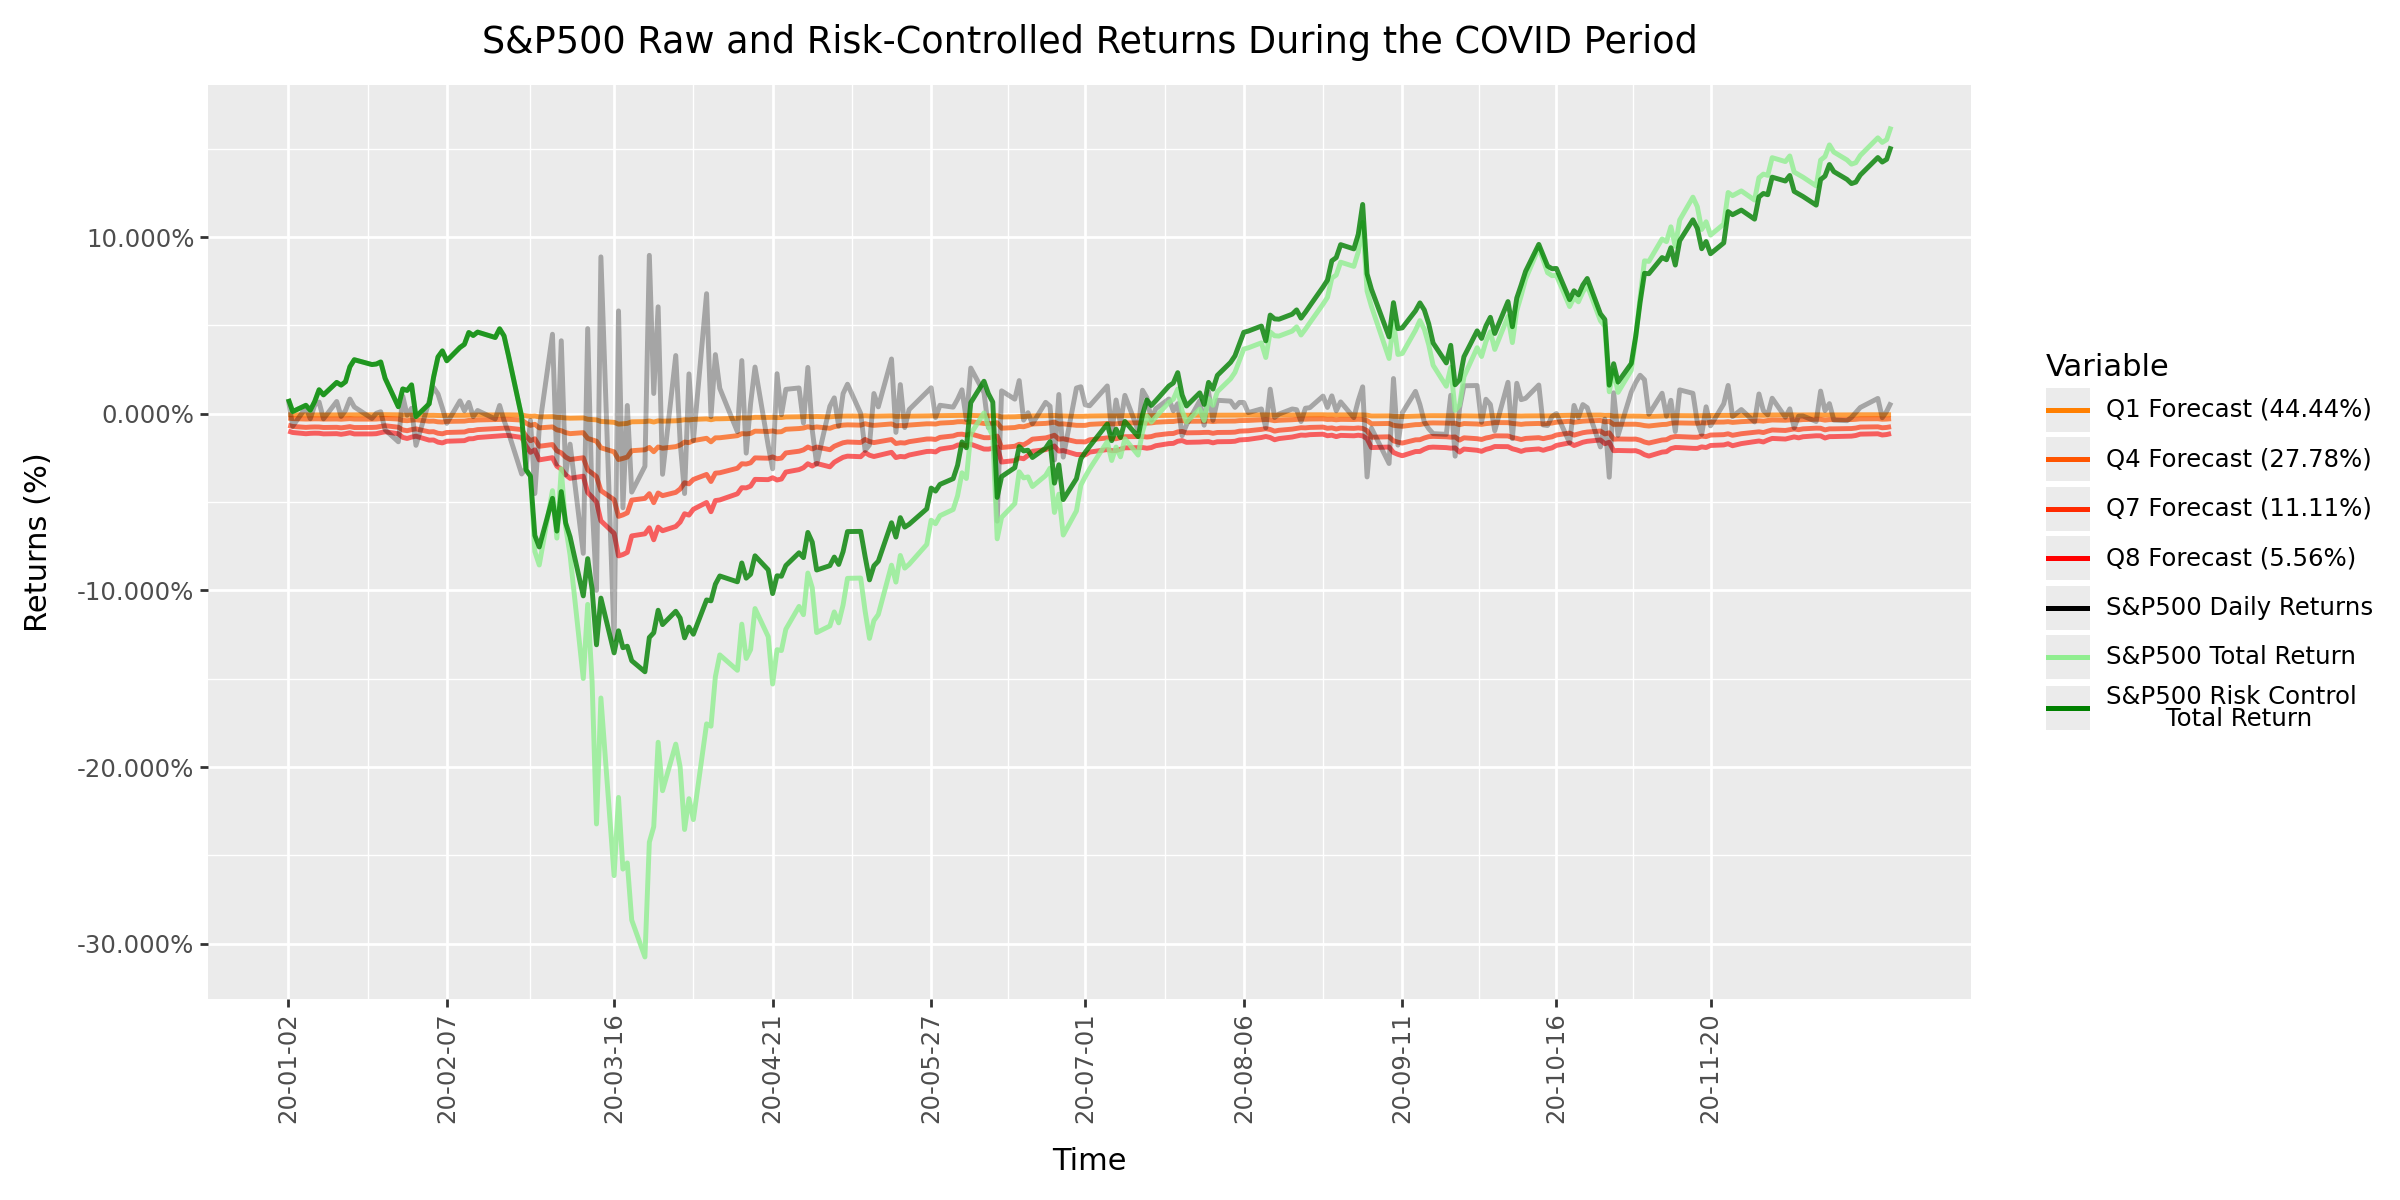

In [61]:
plot_1 = plot_returns(plot_df_1, plot_name ='S&P500 Raw and Risk-Controlled Returns During the COVID Period')
plot_1

##### Weights

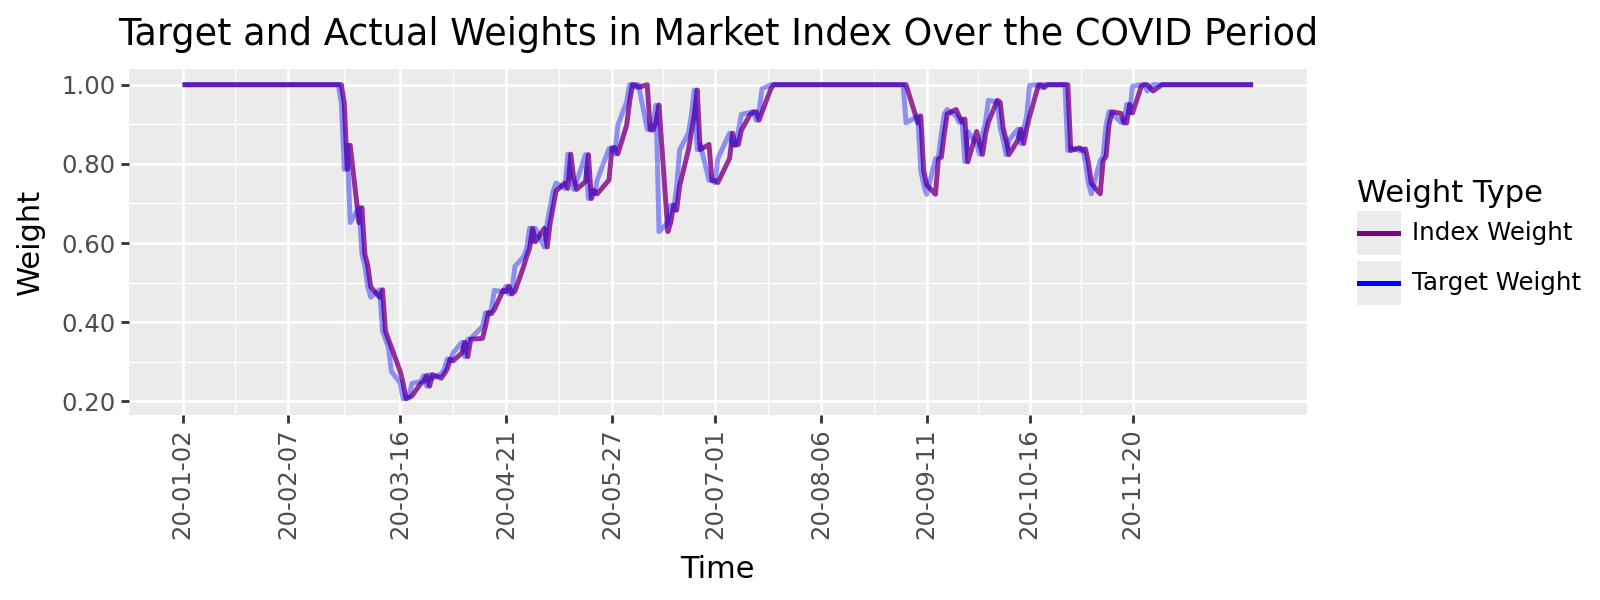

In [62]:
plot_w_targ = plot_w(weights_plot, plot_name='Target and Actual Weights in Market Index Over the COVID Period')
plot_w_targ

#### During the Whole Window of Data

##### Total Returns

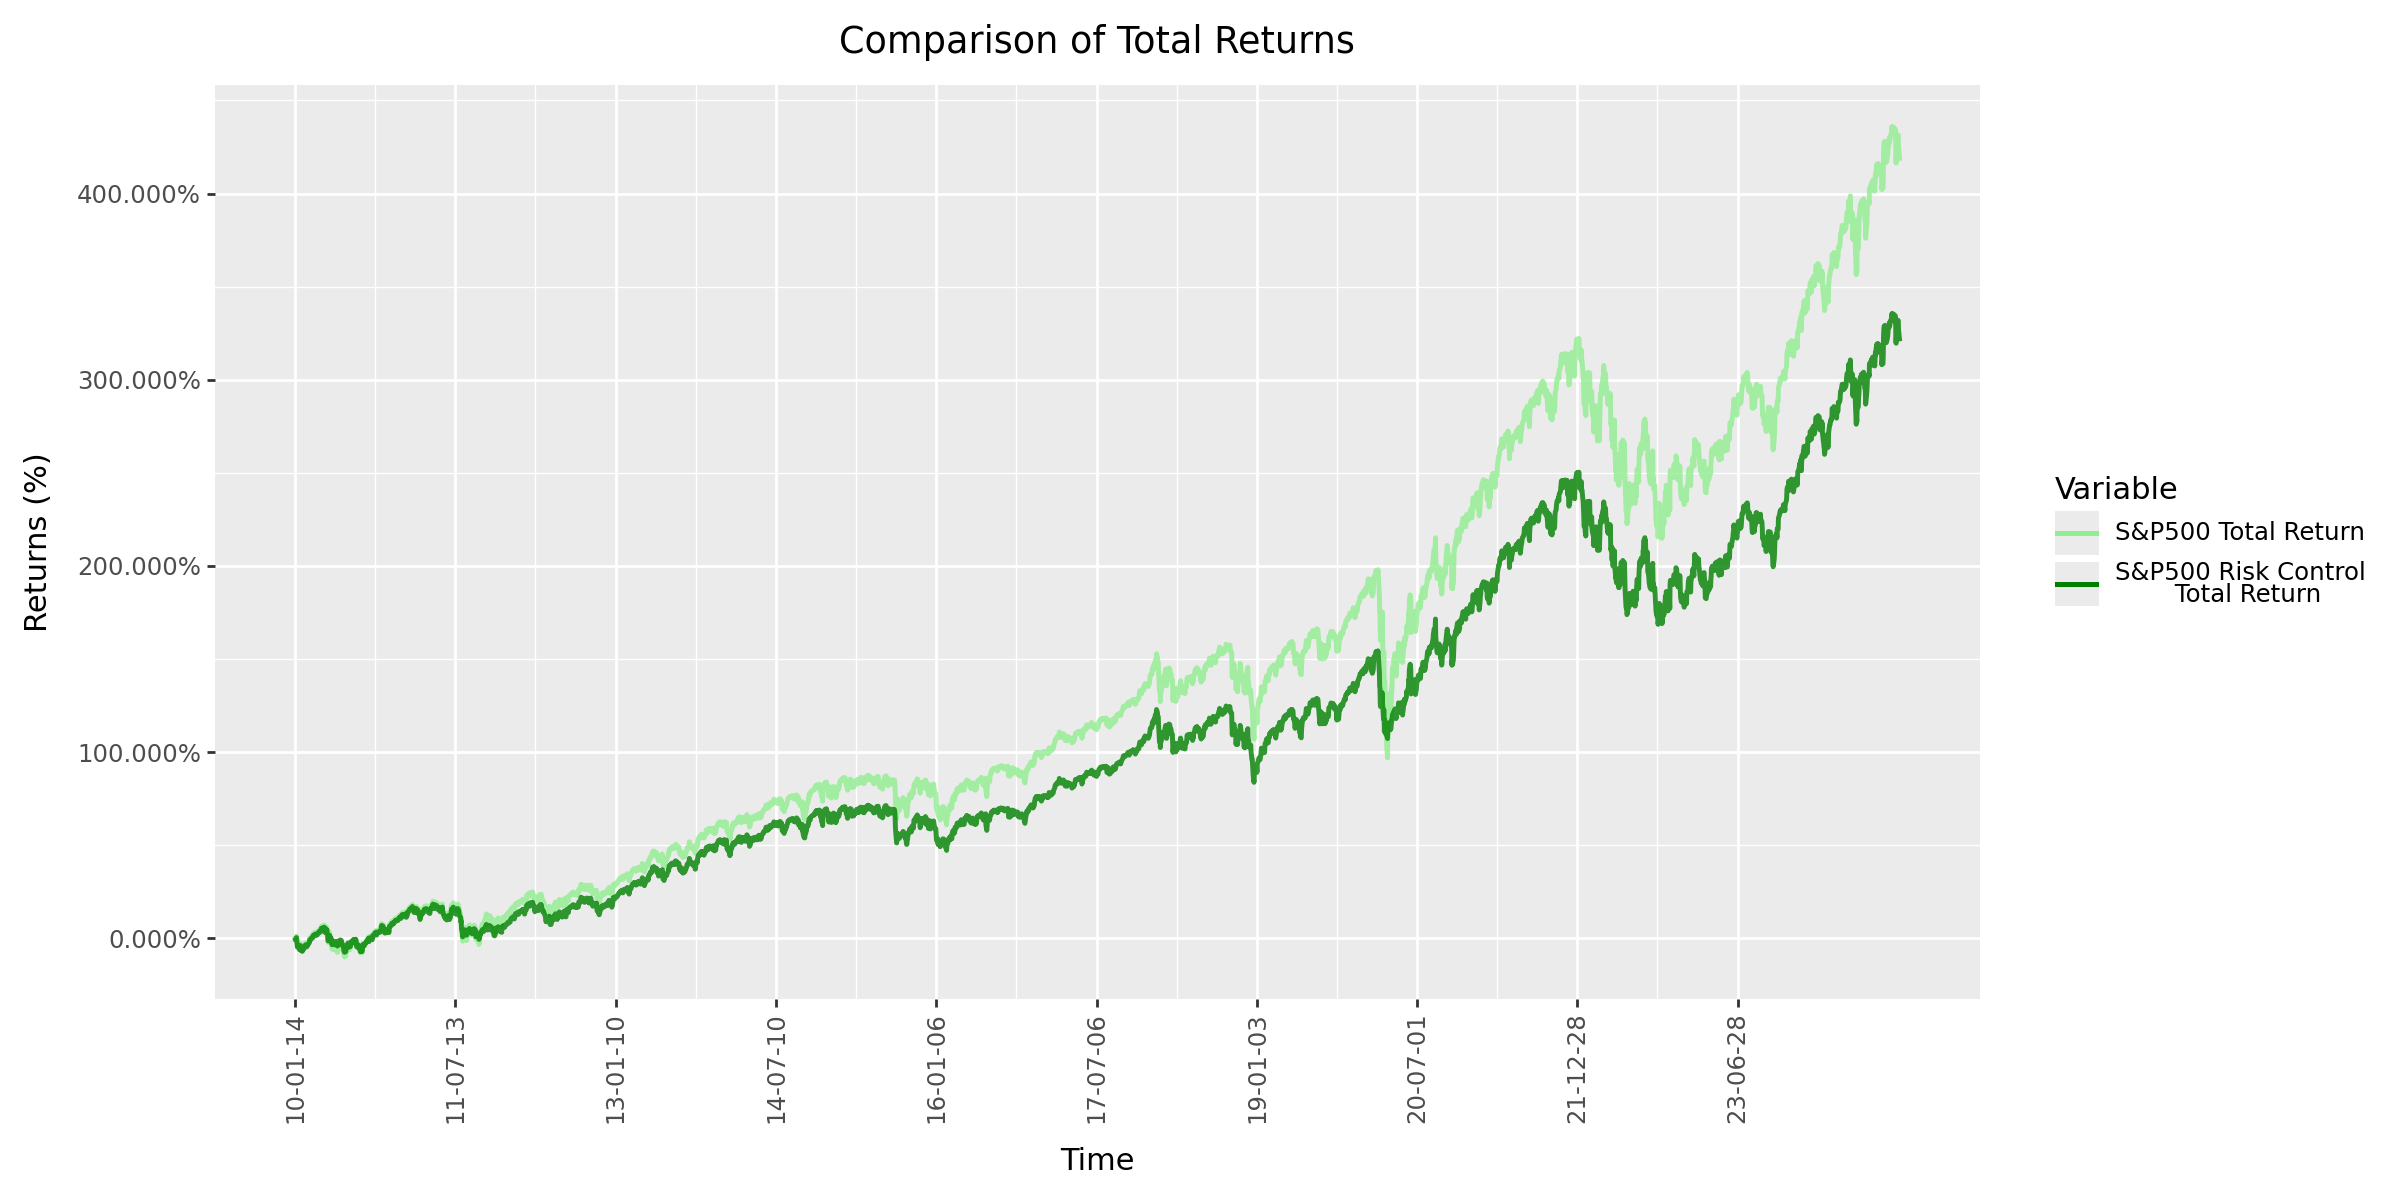

In [63]:
# now do this for the the whole period of data, but instead, get rid of the day returns and the quantiles
# get the total returns for the whole window, but instead, get rid of the day returns and the quantiles
merged_returns_2, weights_df_2 = calc_total_returns(strat_1)

# Melt the dataframe to long format for plotting
plot_df_2 = merged_returns_2.melt(
    id_vars=['time', 'time_label'],
    value_vars=['total_return', 'total_risk_control_return'],
    var_name='return_type',
    value_name='return_value'
)

# Plot the returns for the whole period
plot_2 = plot_returns(plot_df_2)
plot_2

##### Daily Returns and Forecasted Quantiles

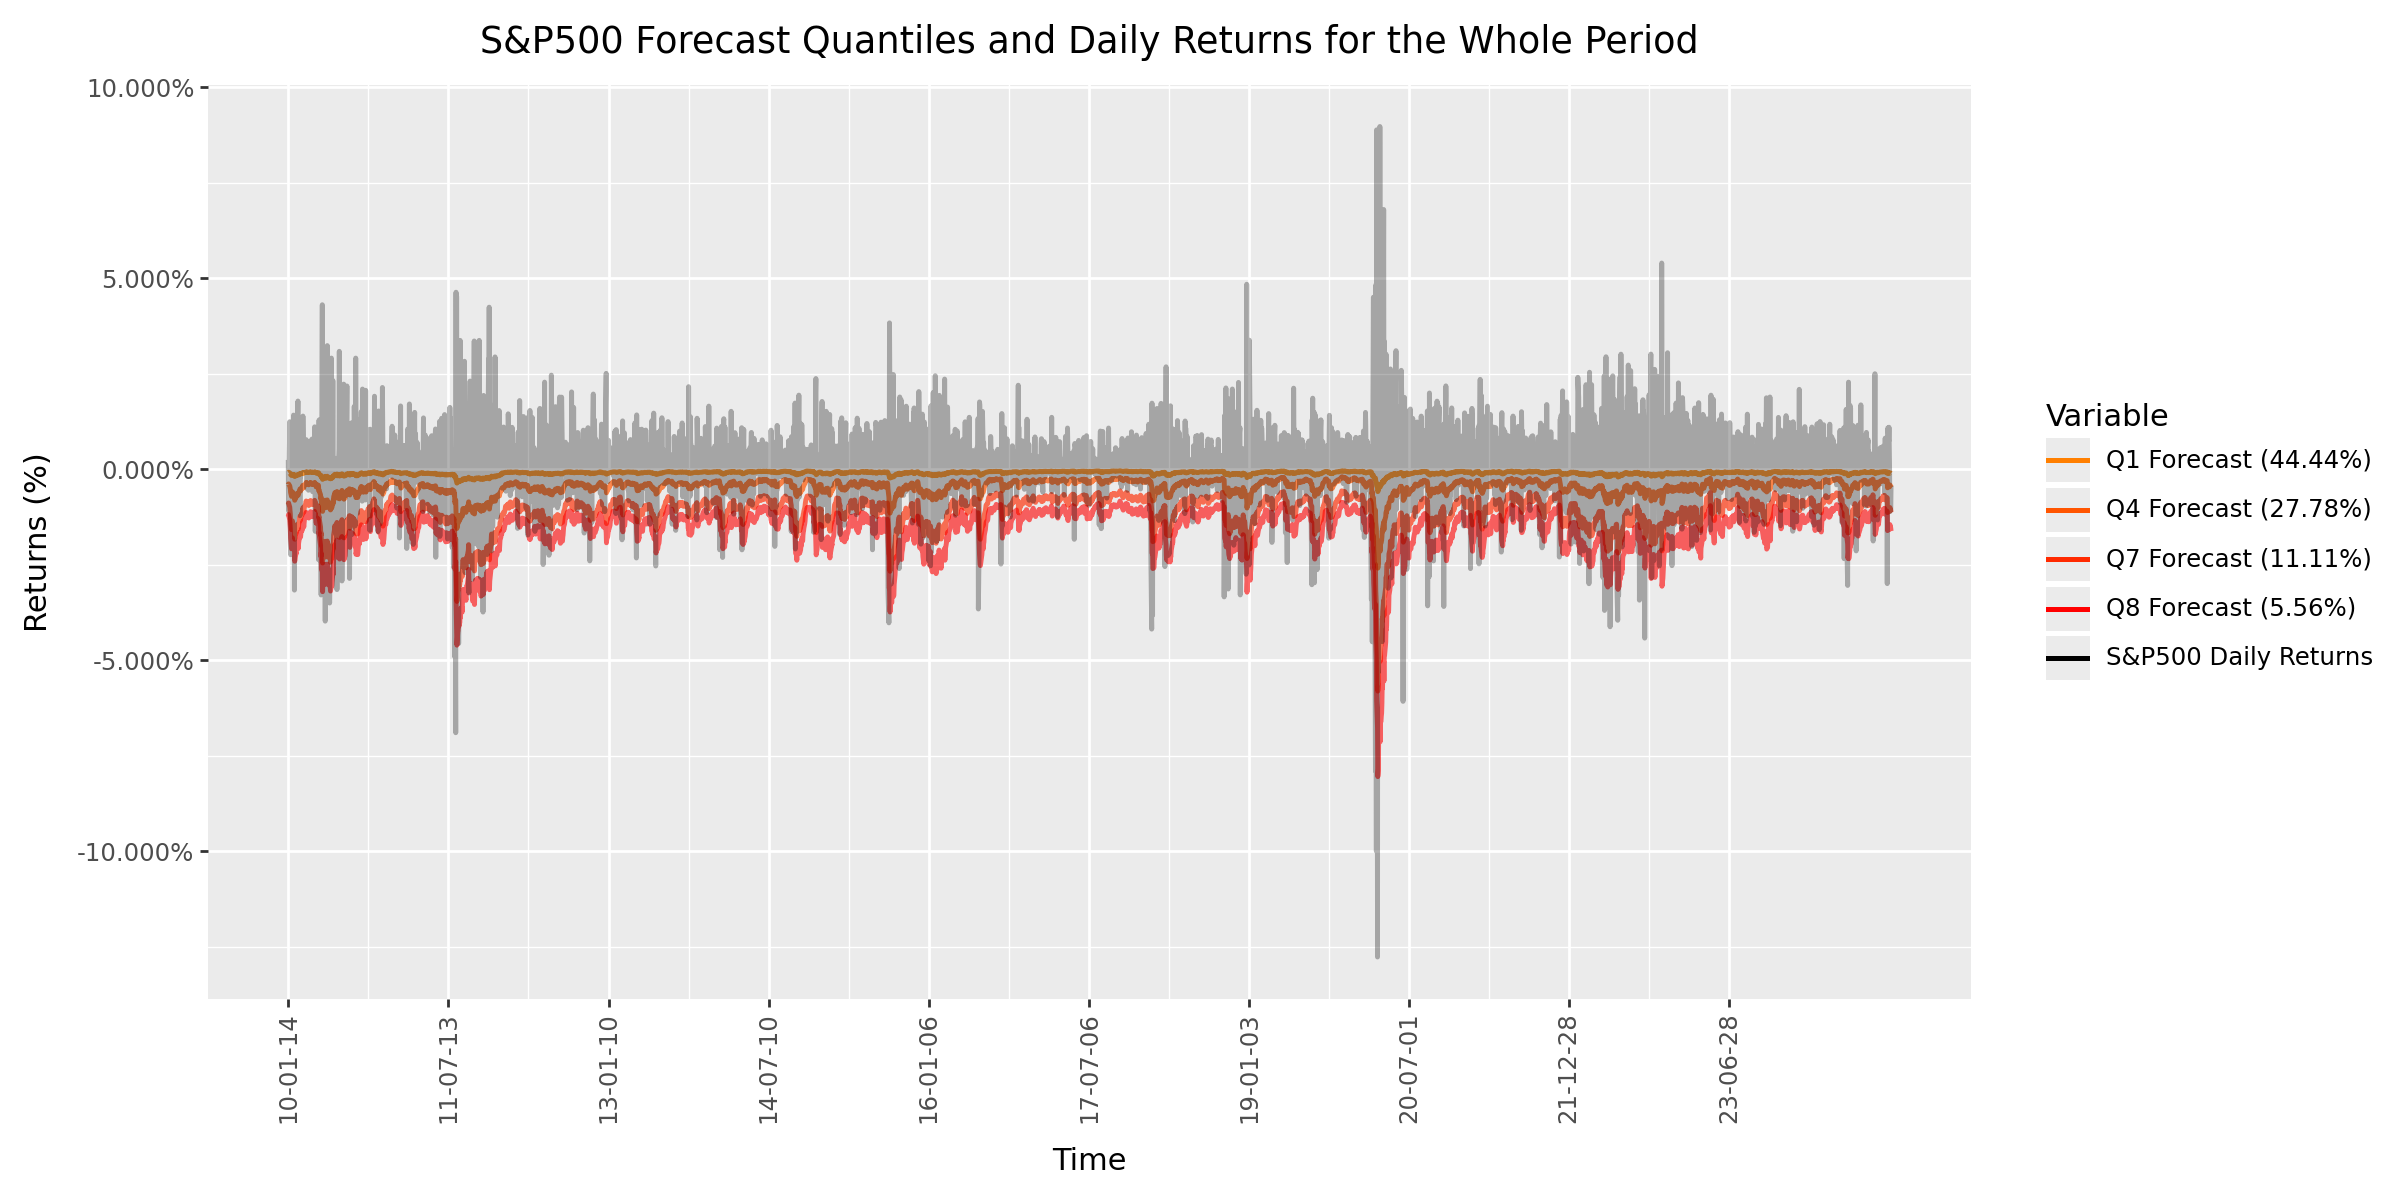

In [64]:
# just the quantiles and day returns for the whole period

# Melt the dataframe to long format for plotting
plot_df_2b = merged_returns_2.melt(
    id_vars=['time', 'time_label'],
    value_vars=['return'] + [f'q_{i}' for i in [1,4,7,8]], 
    var_name='return_type',
    value_name='return_value'
)

# Plot the returns for the whole period
plot_3 = plot_returns(plot_df_2b, plot_name='S&P500 Forecast Quantiles and Daily Returns for the Whole Period')
plot_3


##### Weights

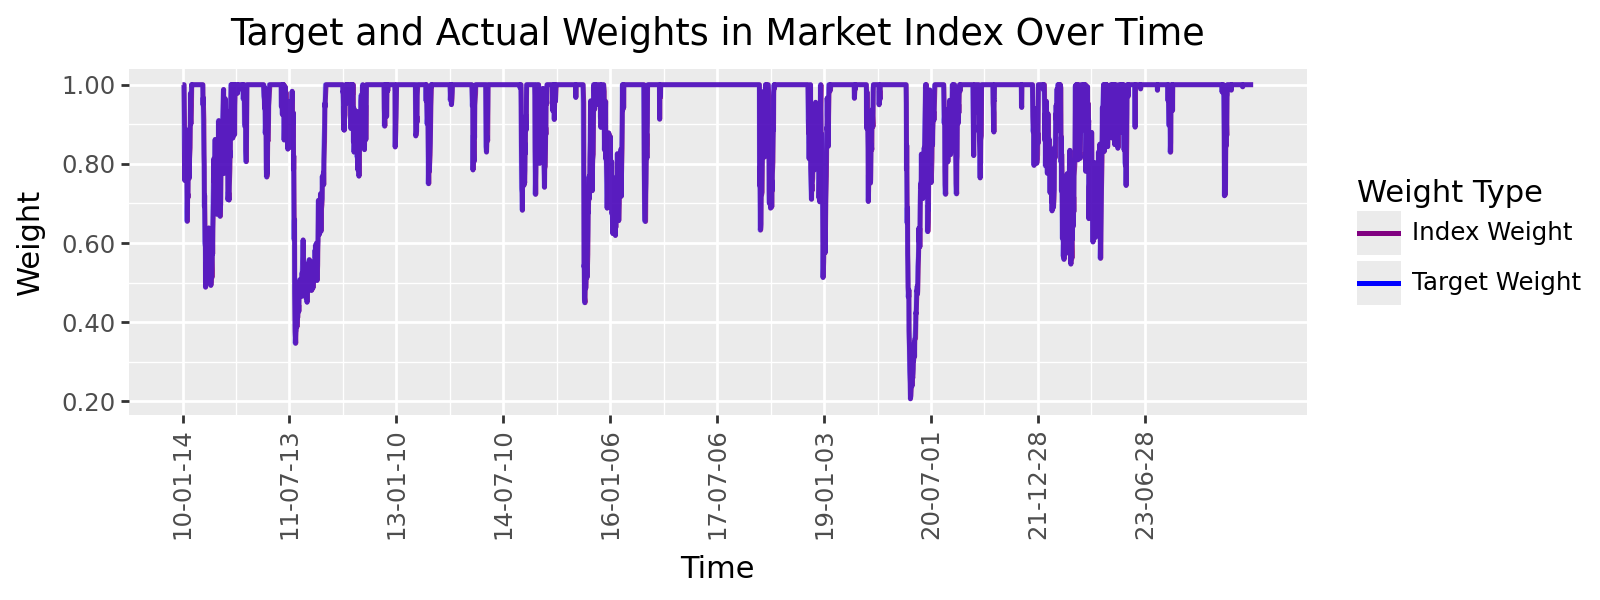

In [65]:
# create another melted DataFrame for the weights
weights_plot_2 = weights_df_2.melt(
    id_vars=['time', 'time_label'],
    var_name='weight_type',
    value_name='weight_value'
)

plot_w_targ_2 = plot_w(weights_plot_2)
plot_w_targ_2

#### During the 2021 Rate Hikes

##### Daily Returns and Forecasted Quantiles with Total Returns

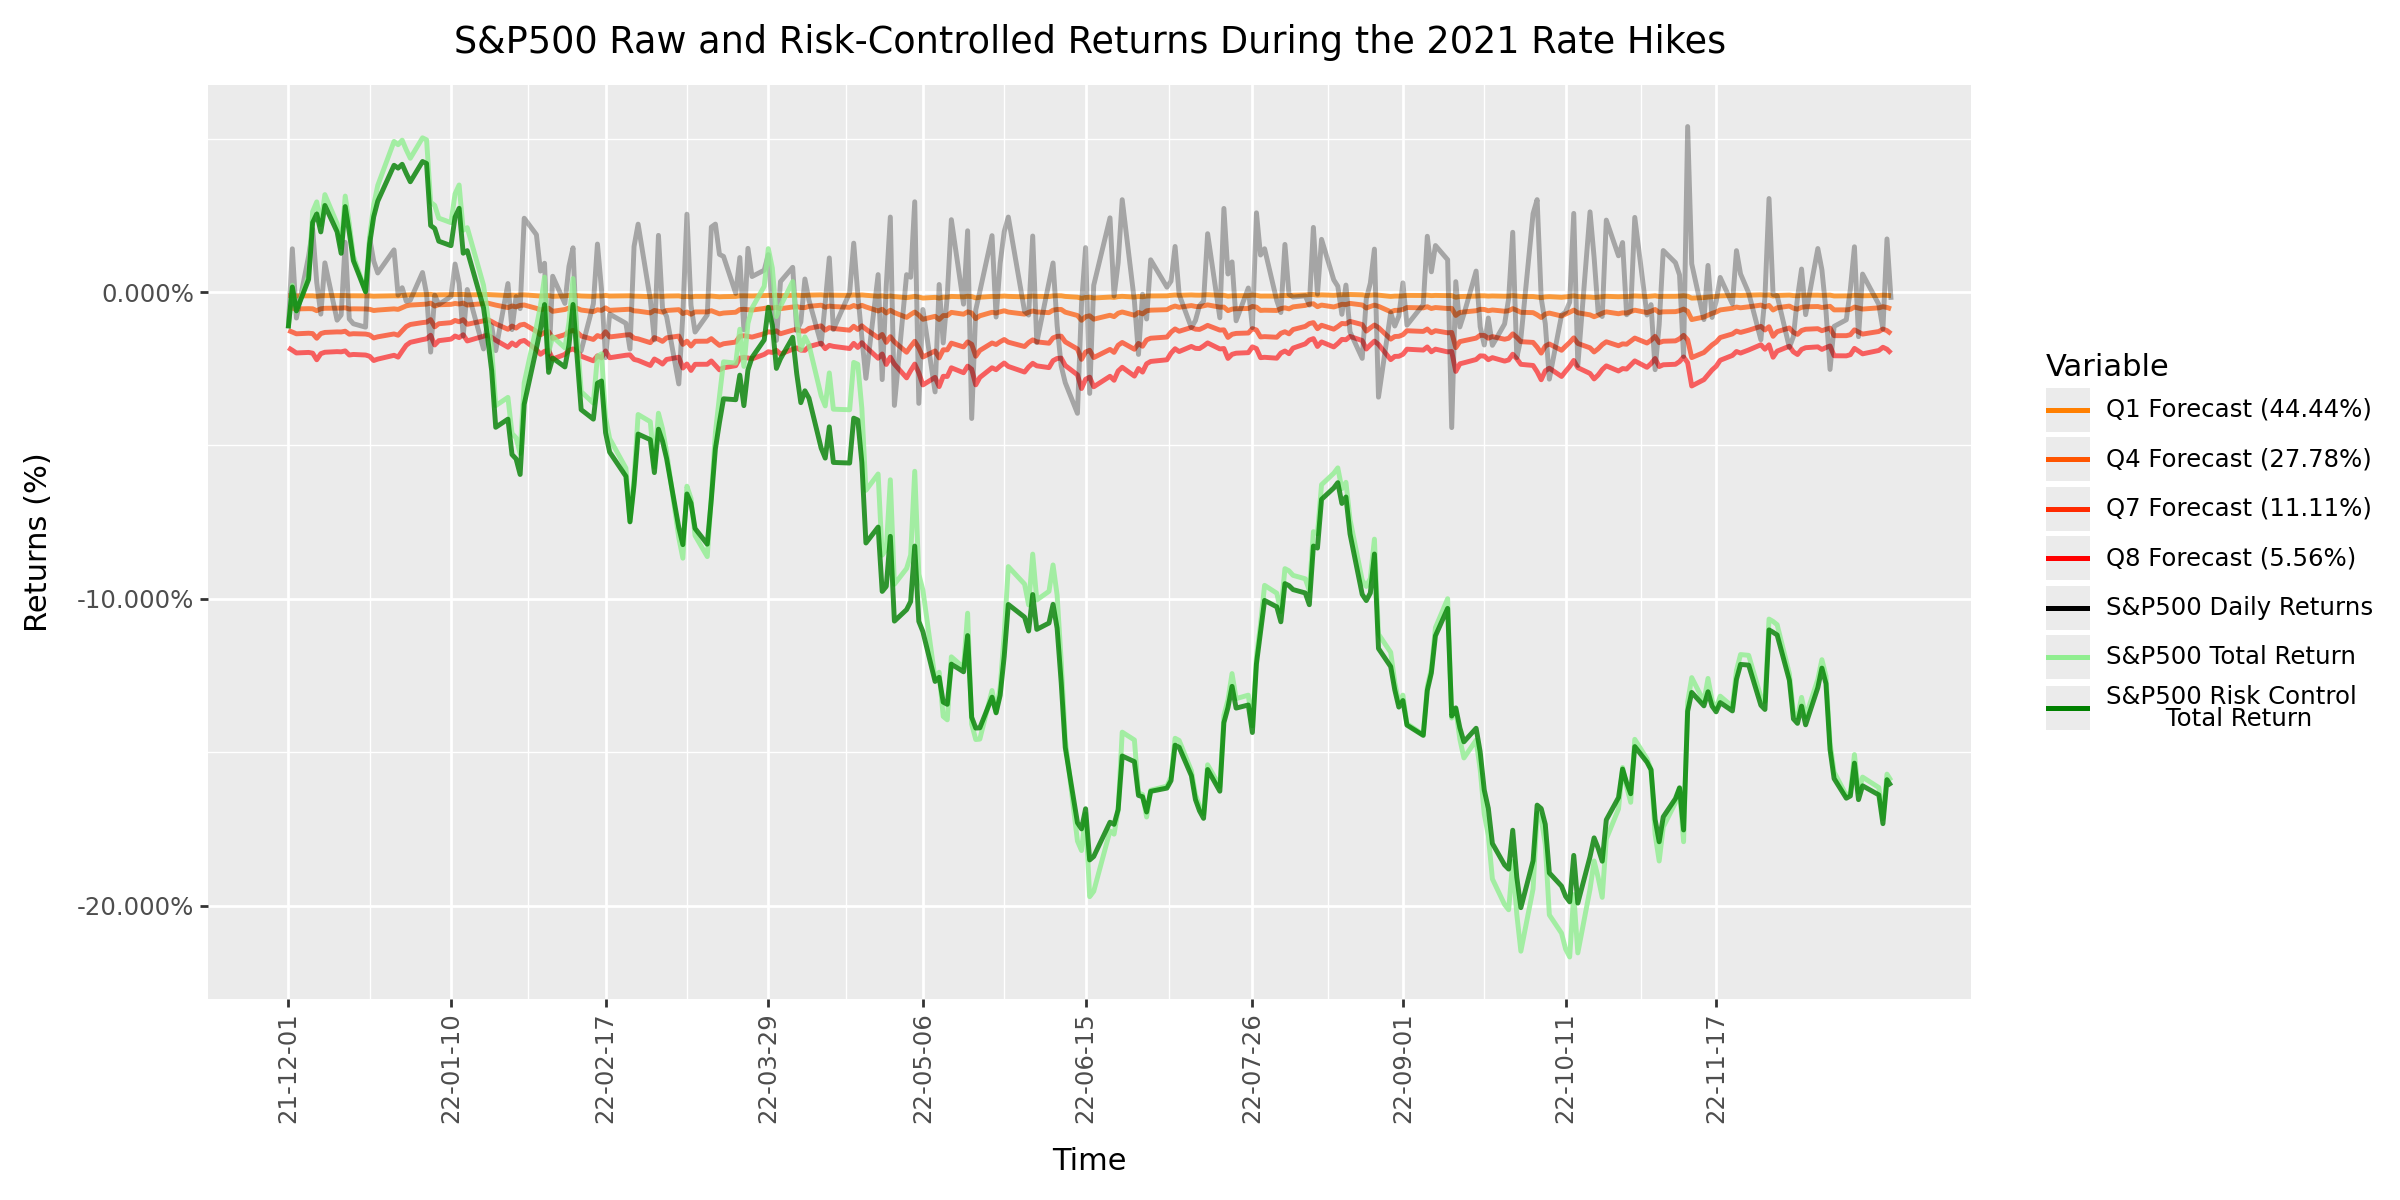

In [66]:
# Get the total returns for the 2021 rate hikes period
# Define the window for the 2021 rate hikes (e.g., 2021-01-01 to 2022-12-31)
merged_returns_3, weights_df_3 = calc_total_returns(strat_1, start_date='2021-12-01', end_date='2022-12-31')

# Drop the return column and any q_i type column
#merged_returns_3 = merged_returns_3.drop(columns=['return'] + [f'q_{i}' for i in [1,4,7,8]])

# Melt the dataframe to long format for plotting
plot_df_3 = merged_returns_3.melt(
    id_vars=['time', 'time_label'],
    var_name='return_type',
    value_name='return_value'
)

# Plot the returns for the pandemic period
plot_3 = plot_returns(plot_df_3, plot_name='S&P500 Raw and Risk-Controlled Returns During the 2021 Rate Hikes')
plot_3

##### Weights

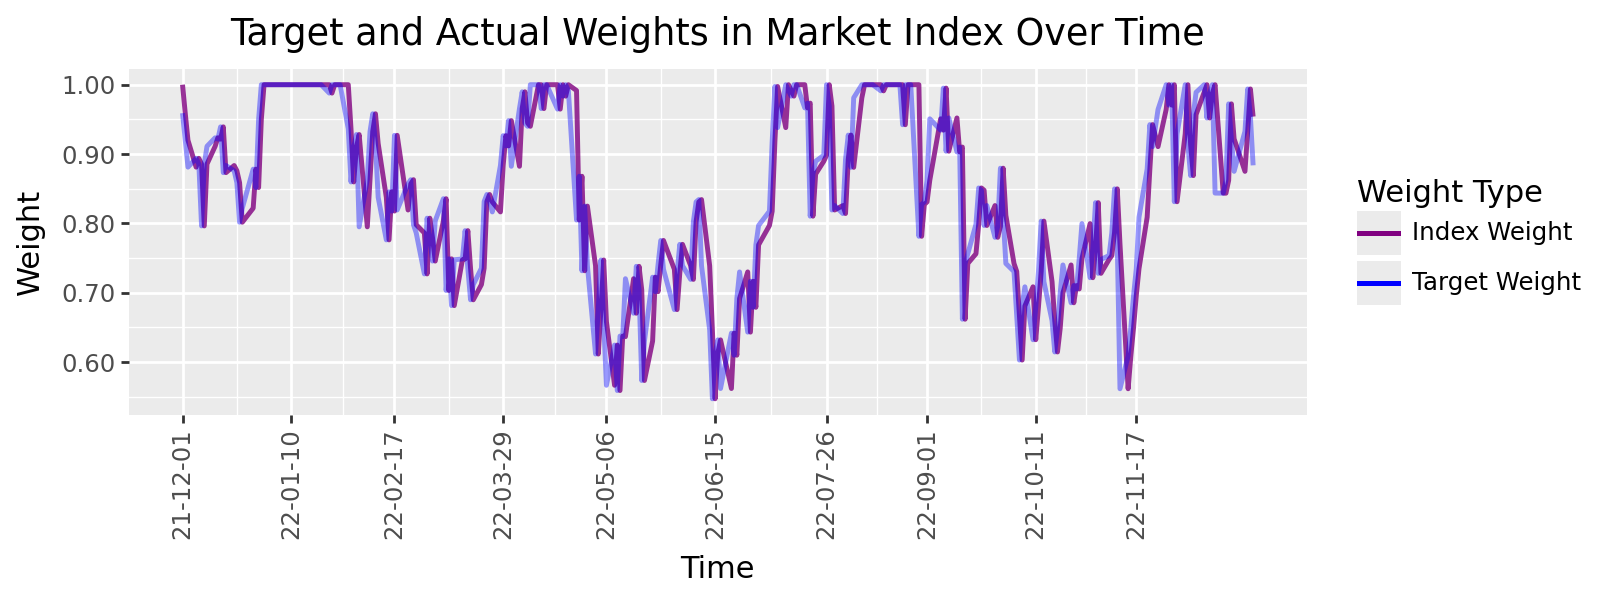

In [67]:
# create another melted DataFrame for the weights
weights_plot_3 = weights_df_3.melt(
    id_vars=['time', 'time_label'],
    var_name='weight_type',
    value_name='weight_value'
)

plot_w_targ_3 = plot_w(weights_plot_3)
plot_w_targ_3